### Price Optimization Machine Learning Model

##### Objective
We want to leverage a machine learning model to help us set optimal prices, the aim would be to increase revenue and/or margin while keeping in mind market conditions and customer trust.

##### Why Now?
I believe we are now well-positioned to design a price optimization model. We have complete access to all our current and historical Brightpearl data, including the pricing information we need.

##### Expected Benefits
- Revenue Uplift: with optimized pricing we can expect improved revenue performance per product
- Margin Protection: An optimized model could help us avoid underpricing
- Insights: Clear understanding of demand elasticity by product & segment

##### Scope
TBC

##### Data Needed

- Historical prices & sales (SKU × date/time × channel)
- Product costs
- Inventory & stockouts
- Promotions & discounts
- Competitor prices ????? Is this achieveable for us
- External demand drivers (seasonality, events)

##### Resources

- Tools: Data warehouse (Perceptium), Python ML stack, Tableau BI dashboard.

### Breakdown of Data from Tables

##### Historical prices & sales (SKU × date/time × channel) / Product costs
Order Table:
- ord_id - Order ID
- ord_invoicetaxDate - Tax Date
- ord_channelId - Channel ID
- ord_orderTypeCode - Type code (used to filter, example: PC or SC is a refund????? Please confirm)

Orderline Table:
- orl_ord_id - Order ID (Number for overall order)
- orl_id - OrderLine ID (Number for orderline, used to show individual lines inside of an order)
- orl_productSku - product SKU
- orl_productId - Product ID
- orl_nominalCode - For filtering (Not needed as a column)
- orl_itemCostValue - Cost (cost price for single unit of product)
- orl_quantity - Quantity (number of items purchased)
- orl_productPriceValue - Price (price of the product at the time the order is placed)
- DO NOT USE - orl_discountPercentage - discount percent on row (not dependable) 


** 02/09/2025 - To test and train Model we are going to use potentially 5 to 10 top selling products, this will make it easier to source competitor pricing for the time being
Products:


Potential products to add:
- Elba Charcoal Wall Hung Basin Drawer Vanity 600mm

In [1]:
# Imports Libraries - Remove unneeded 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
import pyodbc
import statsmodels.api as sm
warnings.filterwarnings('ignore')

from pathlib import Path

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose  

from sklearn.model_selection import train_test_split

##### Loading Dataset

In [2]:
#Load datasets - Original Dataset use sql below for full model
#orders = pd.read_csv('Order.csv')

# --- Step 1: Read the credentials from the text file ---
credentials = {}
try:
    with open('credentials.txt', 'r') as file:
        for line in file:
            # Remove leading/trailing whitespace and split the line at the first '='
            key, value = line.strip().split('=', 1)
            credentials[key.strip()] = value.strip()
except FileNotFoundError:
    print("Error: The 'credentials.txt' file was not found.")
    exit() # or handle the error in another way

# Assign credentials to variables
server_name = credentials.get('server')
database_name = credentials.get('database')
username = credentials.get('username')
password = credentials.get('password')
driver = '{ODBC Driver 17 for SQL Server}'

# Check for missing credentials
if not all([server_name, database_name, username, password]):
    raise ValueError("One or more credentials are missing from the file.")

# --- Step 2: Establish the connection ---
try:
    conn_string = (
        f'DRIVER={driver};'
        f'SERVER={server_name};'
        f'DATABASE={database_name};'
        f'UID={username};'
        f'PWD={password};'
    )
    conn = pyodbc.connect(conn_string)
    print("Connection to Azure SQL Database successful!")

except pyodbc.Error as ex:
    print(f"Error connecting to the database: {ex.args[0]}")
    conn = None

# --- Step 3: Fetch merged data and load into a single DataFrame ---

#points to sql file
sql_path = Path("C:/Users/Devin Ferko/Desktop/Codes/Machine Learning Projects/Price Optimization/HistoricalPricesSales.sql")

with open(sql_path, 'r', encoding='utf-8') as file:
    sql_query = file.read()
    print("SQL query loaded from file.")

if conn:
    try:
        # Reads SQL query from file
        merged_query = sql_query
        
        # Load the joined data directly into a single DataFrame
        orders = pd.read_sql(merged_query, conn)
        print(f"Successfully loaded {len(orders)} rows from the merged query.")
        #print("\nMerged DataFrame Head:")
        #print(orders.head())

    except Exception as e:
        print(f"An error occurred while fetching data: {e}")

    finally:
        conn.close()
        print("Database connection closed.")
else:
    print("Cannot proceed with data fetching. Database connection failed.")

Connection to Azure SQL Database successful!
SQL query loaded from file.
Successfully loaded 6413 rows from the merged query.
Database connection closed.


In [3]:
orders = orders.rename(columns={"Product SKU": "SKU"})
#Info
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6413 entries, 0 to 6412
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Order ID           6413 non-null   int64         
 1   Tax Date           6413 non-null   datetime64[ns]
 2   Net                6413 non-null   float64       
 3   Total              6413 non-null   float64       
 4   Channel Id         6413 non-null   int64         
 5   Type Code          6413 non-null   object        
 6   Orderline ID       6413 non-null   int64         
 7   Product Id         6413 non-null   int64         
 8   SKU                6413 non-null   object        
 9   Product Name       6413 non-null   object        
 10  Quantity           6413 non-null   float64       
 11  Product Value      6413 non-null   float64       
 12  Product Tax Value  6413 non-null   float64       
 13  Price of Product   6413 non-null   float64       
 14  Cost of 

In [4]:
#Null values per columns
orders.isnull().sum()

Order ID             0
Tax Date             0
Net                  0
Total                0
Channel Id           0
Type Code            0
Orderline ID         0
Product Id           0
SKU                  0
Product Name         0
Quantity             0
Product Value        0
Product Tax Value    0
Price of Product     0
Cost of Product      0
Nominal Code         0
dtype: int64

### Promotion Data

We have a couple of CSV's with some promotional data that would be benefical to apply to this notebook

In [5]:
# Summer Sale 2025 - 25th of June to 27th of August
summerSale25 = pd.read_csv("C:/Users/Devin Ferko/Desktop/Codes/Machine Learning Projects/Price Optimization/CSVs/Summer Sale 2025 - Prepped.csv")

#Uncomment the below if needed
#summerSale25.head()

In [6]:
# Spring Sale 2025 - March 5th to April 7th
springSale25 = pd.read_csv("C:/Users/Devin Ferko/Desktop/Codes/Machine Learning Projects/Price Optimization/CSVs/Spring Sale 2025 - prepped.csv")

#Uncomment the below if needed
#springSale25.head()

### Indicate if sale was present and apply discount percentages accordingly

In [7]:
# Add Sale Boolean Column and the discount percentage applied

# --- SUMMER SALE 2025 ---
# Define date windows
sum_start_date = pd.to_datetime('2025-06-25')
sum_end_date = pd.to_datetime('2025-08-27')

#Ensure clean dtypes - types for SKU are string and no trailing space
orders["SKU"] = orders["SKU"].astype(str).str.strip()
summerSale25["SKU"] = summerSale25["SKU"].astype(str).str.strip()

#Add summer sale 2025 column
orders["Summer_Sale"] = (
    orders["Tax Date"].between(sum_start_date, sum_end_date) #True if date falls in between
    & orders["SKU"].isin(summerSale25["SKU"]) #True if SKU matches
).astype("int8") # converts to boolean - t/f or 1/0

#Bring in discount columns from the sale sheet
#Keep only the columns we need from the sale table
discount_cols = ["% off list TW", "% off list DR", "% off list OR"]
orders = orders.merge(
    summerSale25[["SKU"] + discount_cols],
    on="SKU",
    how="left"
)


# Map Channel Id -> the corresponding discount column.
channel_discount_map = {
    "2": "% off list TW",
    "7": "% off list DR",
    "8": "% off list OR"
}

channel_key = orders["Channel Id"].astype(str).str.strip() # Ensure Channel Id's are strings
chosen_col = channel_key.map(channel_discount_map)  # per-row column name to use

# Vectorized pick of the right discount per row
disc_df = orders[discount_cols] #seperates discount values to seperate df
col_indexer = pd.Index(discount_cols).get_indexer(chosen_col) # converts column names in chosen_col into numeric indices so we can index the DataFrame efficiently.
row_indexer = np.arange(len(orders)) #array of row numbers [0, 1, 2, ..., n-1]

result = np.full(len(orders), np.nan, dtype=float) #empty array to hold discount values
in_window = orders["Tax Date"].between(sum_start_date, sum_end_date) #True if in window
valid_choice = col_indexer >= 0 #True if valid discount column exists for channel
mask = in_window & valid_choice #only select discount for orders in window and with valid channel

# Pull the values only where in window and with a valid channel/discount
result[mask] = disc_df.to_numpy()[row_indexer[mask], col_indexer[mask]]
orders["sumsale25_discount_percent"] = result

#If you prefer 0 instead of NaN when not applicable, uncomment:
orders["sumsale25_discount_percent"] = orders["sumsale25_discount_percent"].fillna(0)

#Drops unwanted columns
orders = orders.drop(['% off list TW', '% off list DR', '% off list OR'], axis=1)

# --- SPRING SALE 2025 ---
# Define date windows
spr_start_date = pd.to_datetime('2025-03-05')
spr_end_date = pd.to_datetime('2025-04-07')

#Ensure clean dtypes - types for SKU are string and no trailing space
orders["SKU"] = orders["SKU"].astype(str).str.strip()
springSale25["SKU"] = springSale25["SKU"].astype(str).str.strip()

#Add summer sale 2025 column
orders["Spring_Sale"] = (
    orders["Tax Date"].between(spr_start_date, spr_end_date) #True if date falls in between
    & orders["SKU"].isin(springSale25["SKU"]) #True if SKU matches
).astype("int8") # converts to boolean - t/f or 1/0

#Bring in discount columns from the sale sheet
#Keep only the columns we need from the sale table
discount_cols = ["% off list TW", "% off list DR", "% off list OR"]
orders = orders.merge(
    springSale25[["SKU"] + discount_cols],
    on="SKU",
    how="left"
)


# Map Channel Id -> the corresponding discount column.
channel_discount_map = {
    "2": "% off list TW",
    "7": "% off list DR",
    "8": "% off list OR"
}

channel_key = orders["Channel Id"].astype(str).str.strip() # Ensure Channel Id's are strings
chosen_col = channel_key.map(channel_discount_map)  # per-row column name to use

# Vectorized pick of the right discount per row
disc_df = orders[discount_cols] #seperates discount values to seperate df
col_indexer = pd.Index(discount_cols).get_indexer(chosen_col) # converts column names in chosen_col into numeric indices so we can index the DataFrame efficiently.
row_indexer = np.arange(len(orders)) #array of row numbers [0, 1, 2, ..., n-1]

result = np.full(len(orders), np.nan, dtype=float) #empty array to hold discount values
in_window = orders["Tax Date"].between(spr_start_date, spr_end_date) #True if in window
valid_choice = col_indexer >= 0 #True if valid discount column exists for channel
mask = in_window & valid_choice #only select discount for orders in window and with valid channel

# Pull the values only where in window and with a valid channel/discount
result[mask] = disc_df.to_numpy()[row_indexer[mask], col_indexer[mask]]
orders["sprsale25_discount_percent"] = result

#If you prefer 0 instead of NaN when not applicable, uncomment:
orders["sprsale25_discount_percent"] = orders["sprsale25_discount_percent"].fillna(0)

#Drops unwanted columns
orders = orders.drop(['% off list TW', '% off list DR', '% off list OR'], axis=1)

# --- TAX MONTH AND SEASONS ---
# Extract the month number from Tax Date
orders["TaxMonth"] = orders["Tax Date"].dt.month

# Flag if TaxMonth is in summer (June=6, July=7, August=8 for example)
orders["Winter"] = orders["TaxMonth"].isin([12, 1, 2]).astype(int)
orders["Spring"] = orders["TaxMonth"].isin([3, 4, 5]).astype(int)
orders["Summer"] = orders["TaxMonth"].isin([6, 7, 8]).astype(int)
orders["Fall"] = orders["TaxMonth"].isin([9, 10, 11]).astype(int)


In [8]:
# Uncomment the below if needed
#orders.info() 
#orders.to_csv('out.csv') 

### Product Attributes - Akeneo data

In [9]:
# Reads akeneo product attribute dataset
prdAttr = pd.read_csv("C:/Users/Devin Ferko/Desktop/Codes/Machine Learning Projects/Price Optimization/CSVs/Akeneo Product Attributes - Sheet1.csv")

#Uncomment the below if needed
#prdAttr.head()

In [10]:
# Merge attribute data
orders = orders.merge(prdAttr, on='SKU', how='left')

#Uncomment the below if needed
#orders.info()

In [11]:
# Reads akeneo product attribute dataset
compPrice = pd.read_csv("C:/Users/Devin Ferko/Desktop/Codes/Machine Learning Projects/Price Optimization/CSVs/Competitor Pricing.csv")

compPrice.drop(['Product Name'], axis=1, inplace=True)
#Uncomment the below if needed
#compPrice.head()

In [12]:
# Merge attribute data
orders = orders.merge(compPrice, on='SKU', how='left')

#Uncomment the below if needed
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6413 entries, 0 to 6412
Data columns (total 76 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Order ID                          6413 non-null   int64         
 1   Tax Date                          6413 non-null   datetime64[ns]
 2   Net                               6413 non-null   float64       
 3   Total                             6413 non-null   float64       
 4   Channel Id                        6413 non-null   int64         
 5   Type Code                         6413 non-null   object        
 6   Orderline ID                      6413 non-null   int64         
 7   Product Id                        6413 non-null   int64         
 8   SKU                               6413 non-null   object        
 9   Product Name                      6413 non-null   object        
 10  Quantity                          6413 non-null 

### Next Steps

This dataset works as a great base but we could benefit from:

- Customer Data

however until this is avaialble we will move on with the above dataset.

In [13]:
# The following should be adapted as the dataset grows
# This step is uded to drop epmty columns
# this will cut down any 'noisy' data that may not be needed

empty_cols = [col for col in orders.columns if orders[col].isnull().all()]
orders = orders.drop(columns=empty_cols)

# Handles type columns
# Uncomment 'OR' attributes if they occur when dataset fully built out 
orders["Type"] = np.where(
    orders["Type DR"] != "", orders["Type DR"],
    np.where(
        orders["Type TW"] != "", orders["Type TW"],
        #np.where(
            #orders["Type OR"] != "", orders["Type OR"],
            np.nan
        )
    )
#)

# Handles Brand columns
# Uncomment 'OR' attributes if they occur when dataset fully built out 
orders["Brand"] = np.where(
    orders["Brand DR"] != "", orders["Brand DR"],
    np.where(
        orders["Brand TW"] != "", orders["Brand TW"],
        #np.where(
            #orders["Brand OR"] != "", orders["Brand OR"],
            np.nan
        )
    )
#)

# Handles LaunchDate columns
# Uncomment 'OR' attributes if they occur when dataset fully built out 
orders["LaunchDate"] = np.where(
    orders["LaunchDate DR"] != "", orders["LaunchDate DR"],
    np.where(
        orders["LaunchDate TW"] != "", orders["LaunchDate TW"],
        #np.where(
            #orders["LaunchDate OR"] != "", orders["LaunchDate OR"],
            np.nan
        )
    )
#)

orders = orders.drop(columns=["Type DR", "Type TW"]) #, "Type OR"])
orders = orders.drop(columns=["Brand DR", "Brand TW"]) #, "Brand OR"])
orders = orders.drop(columns=["LaunchDate DR", "LaunchDate TW"]) #, "Brand OR"])


#Uncomment if needed
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6413 entries, 0 to 6412
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Order ID                          6413 non-null   int64         
 1   Tax Date                          6413 non-null   datetime64[ns]
 2   Net                               6413 non-null   float64       
 3   Total                             6413 non-null   float64       
 4   Channel Id                        6413 non-null   int64         
 5   Type Code                         6413 non-null   object        
 6   Orderline ID                      6413 non-null   int64         
 7   Product Id                        6413 non-null   int64         
 8   SKU                               6413 non-null   object        
 9   Product Name                      6413 non-null   object        
 10  Quantity                          6413 non-null 

Based on the above we have low values for Launch Date, Brand, Type, and Orientation. We are going to drop these for the current dataset but the below should be commented-out once the dataset grows

In [14]:
# Comment out when needed
# Based on the above we have low values for Launch Date, Brand, Type, and Orientation
orders = orders.drop(columns=["LaunchDate", "Brand", "Type", "Orientation"]) 

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6413 entries, 0 to 6412
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Order ID                          6413 non-null   int64         
 1   Tax Date                          6413 non-null   datetime64[ns]
 2   Net                               6413 non-null   float64       
 3   Total                             6413 non-null   float64       
 4   Channel Id                        6413 non-null   int64         
 5   Type Code                         6413 non-null   object        
 6   Orderline ID                      6413 non-null   int64         
 7   Product Id                        6413 non-null   int64         
 8   SKU                               6413 non-null   object        
 9   Product Name                      6413 non-null   object        
 10  Quantity                          6413 non-null 

### Next Steps will be Visualisations and further feature engineering:

##### Visualizations

- Price and Sales: Plot Price of Product against Quantity to see if there's a clear price elasticity. Do sales decrease as prices increase?

- Time-based Trends: Examine Total or Quantity over time using Tax Date. This can reveal seasonality, which may affect pricing decisions. You already have Summer, Winter, etc., which is a great start.

- Product Attributes: Compare prices (Price of Product) and sales (Quantity) across different product attributes like Family, Material, and Finish. This can help you understand which attributes are associated with higher or lower prices and sales.

Number of unique products: 3


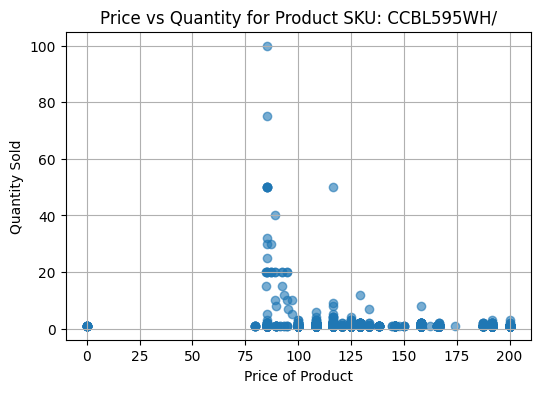

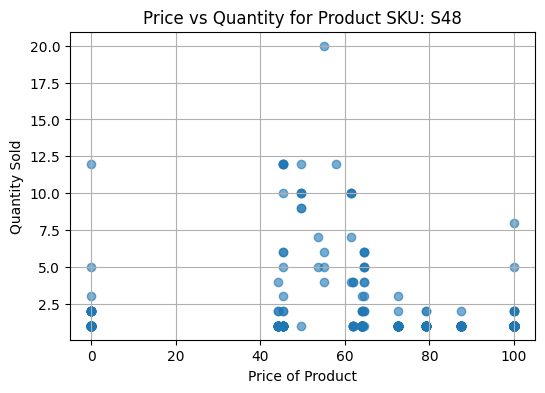

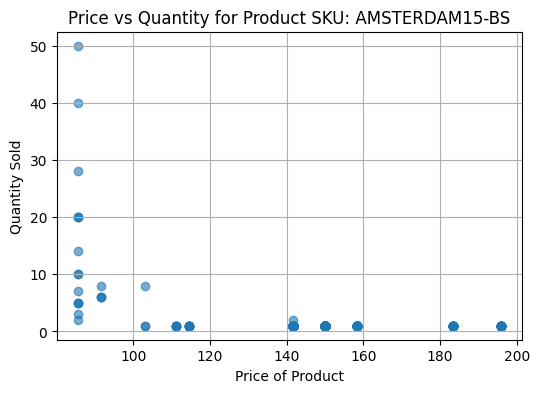

In [15]:
# Price and Sales

products = orders['SKU'].unique()
print(f"Number of unique products: {len(products)}")

for product in products:
    subset = orders[orders['SKU'] == product]

    plt.figure(figsize=(6, 4))
    plt.scatter(subset['Price of Product'], subset['Quantity'], alpha=0.6)
    plt.title(f'Price vs Quantity for Product SKU: {product}')
    plt.xlabel('Price of Product')
    plt.ylabel('Quantity Sold')
    plt.grid(True)
    plt.show()

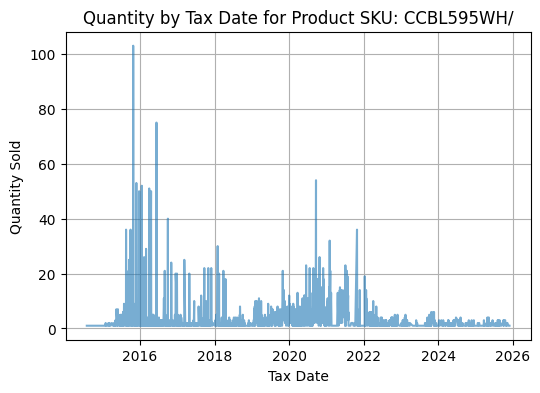

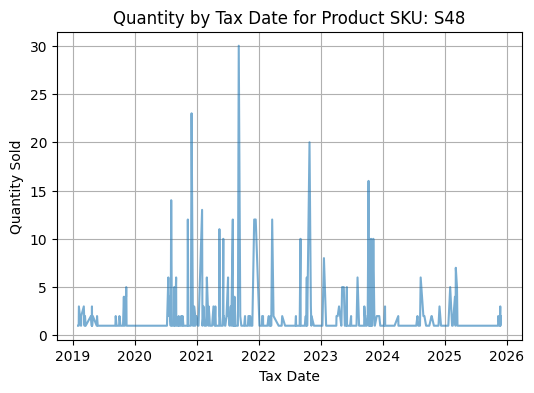

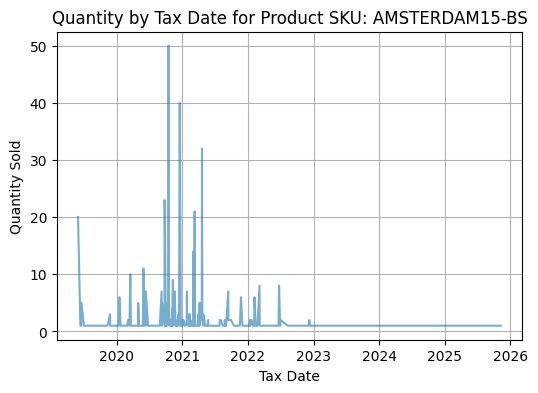

In [16]:
# Seasonality and Trends

#products = orders['SKU'].unique()
#print(f"Number of unique products: {len(products)}")

for product in products:
    subset = orders[orders['SKU'] == product]
    daily_qty = subset.groupby('Tax Date')['Quantity'].sum()

    plt.figure(figsize=(6, 4))
    plt.plot(daily_qty.index, daily_qty.values, alpha=0.6)
    plt.title(f'Quantity by Tax Date for Product SKU: {product}')
    plt.xlabel('Tax Date')
    plt.ylabel('Quantity Sold')
    plt.grid(True)
    plt.show()

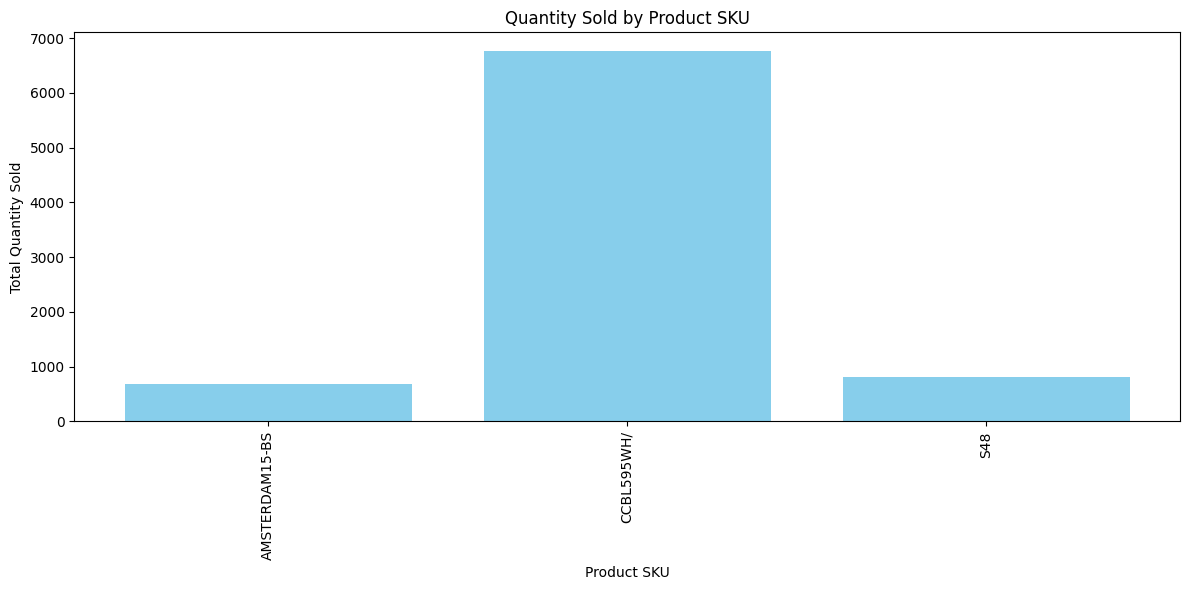

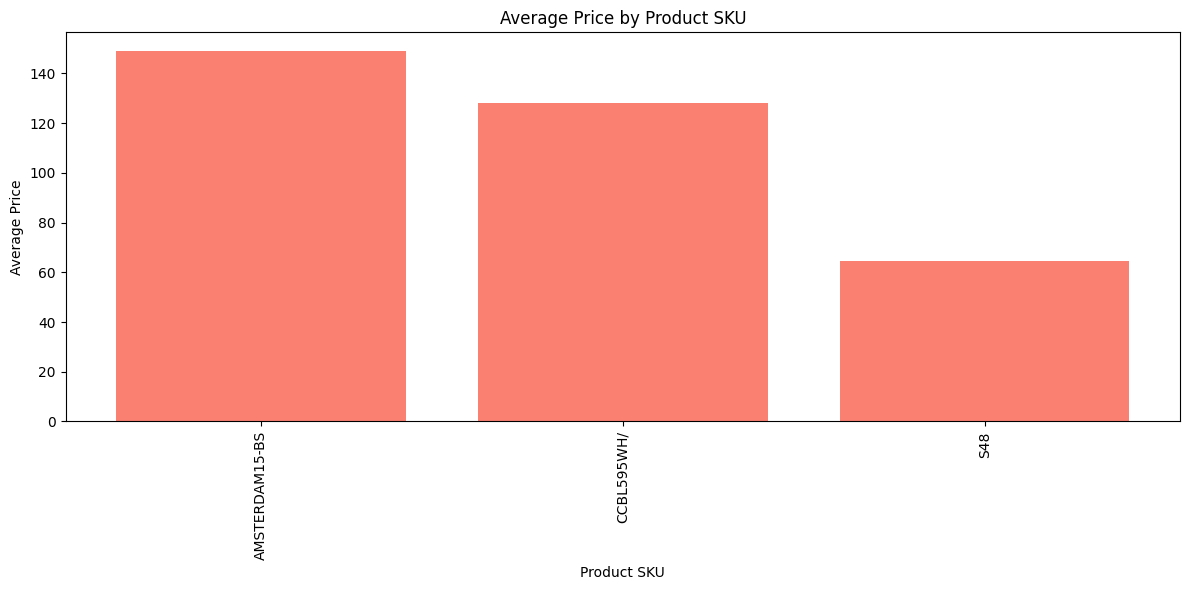

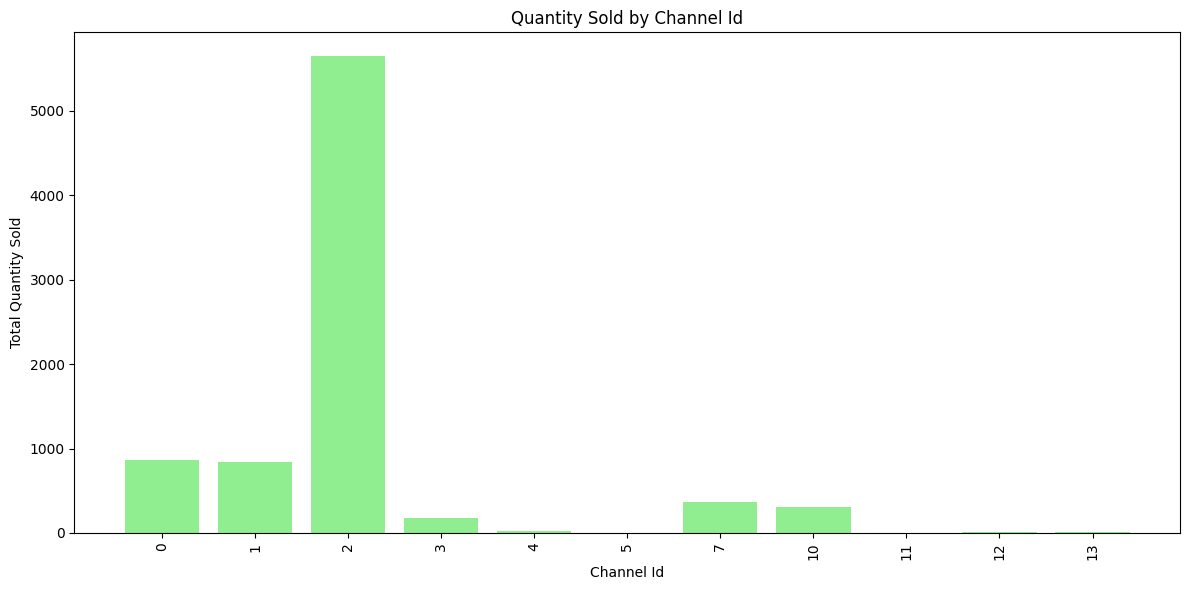

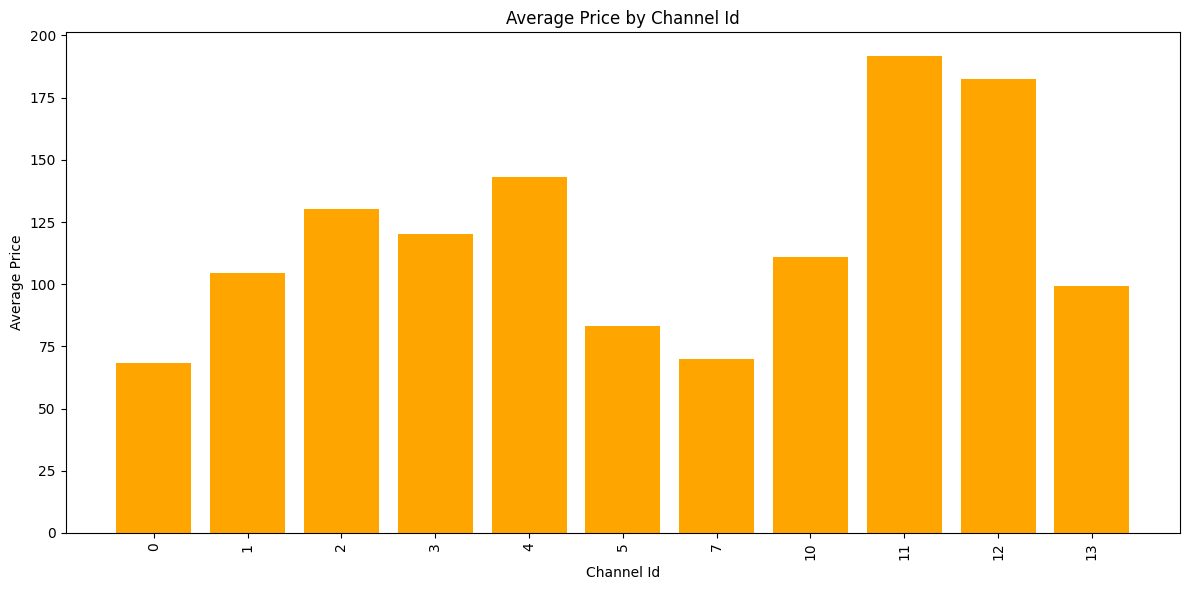

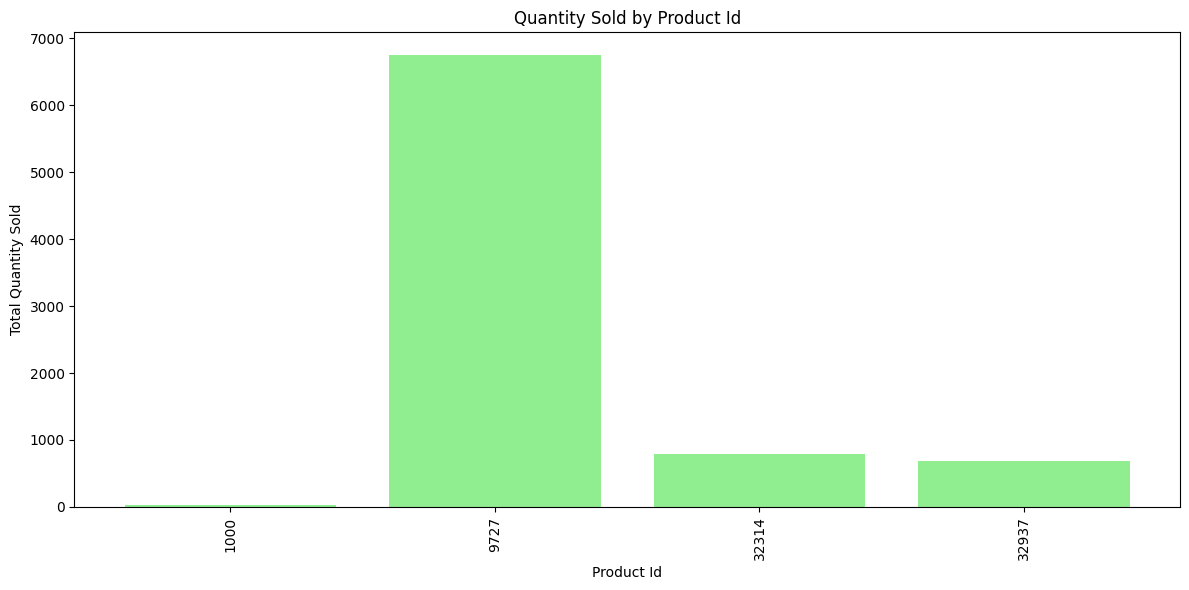

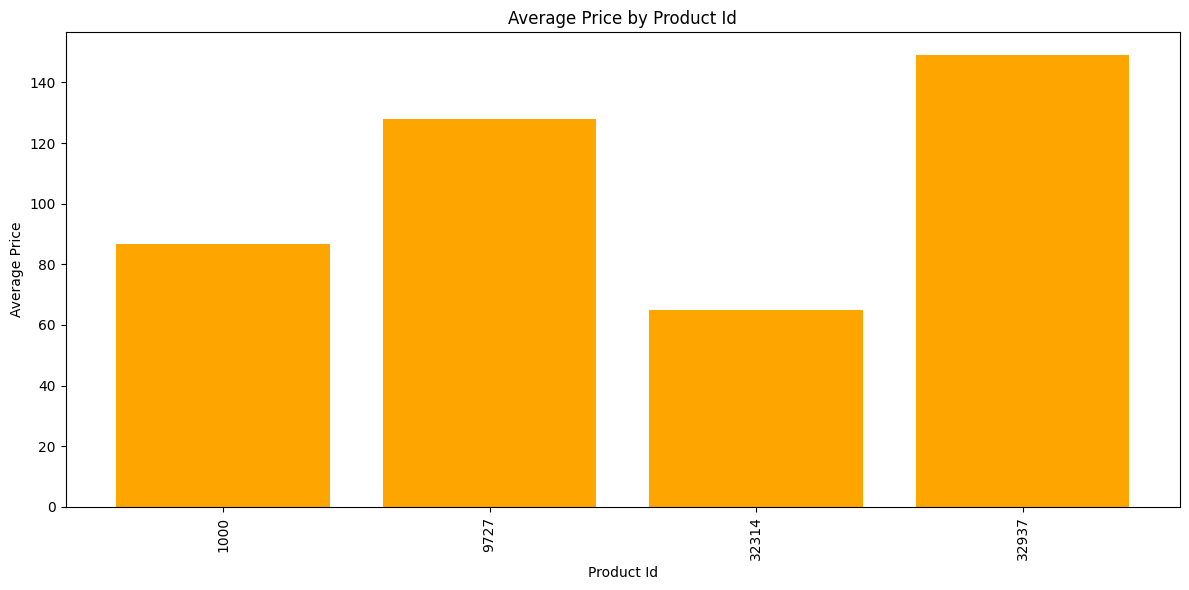

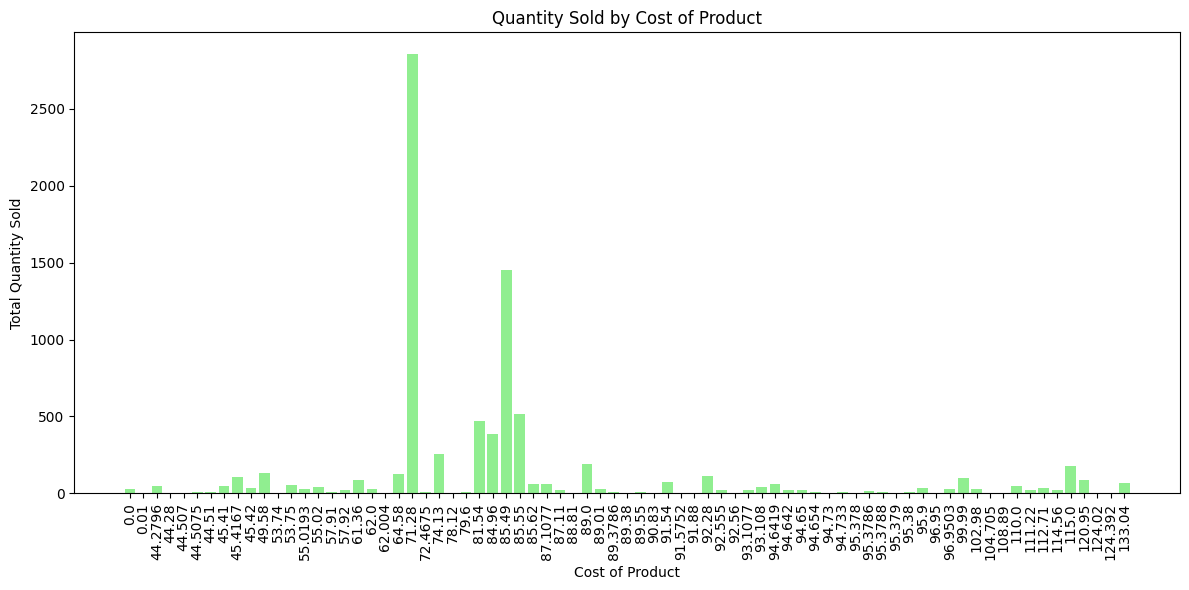

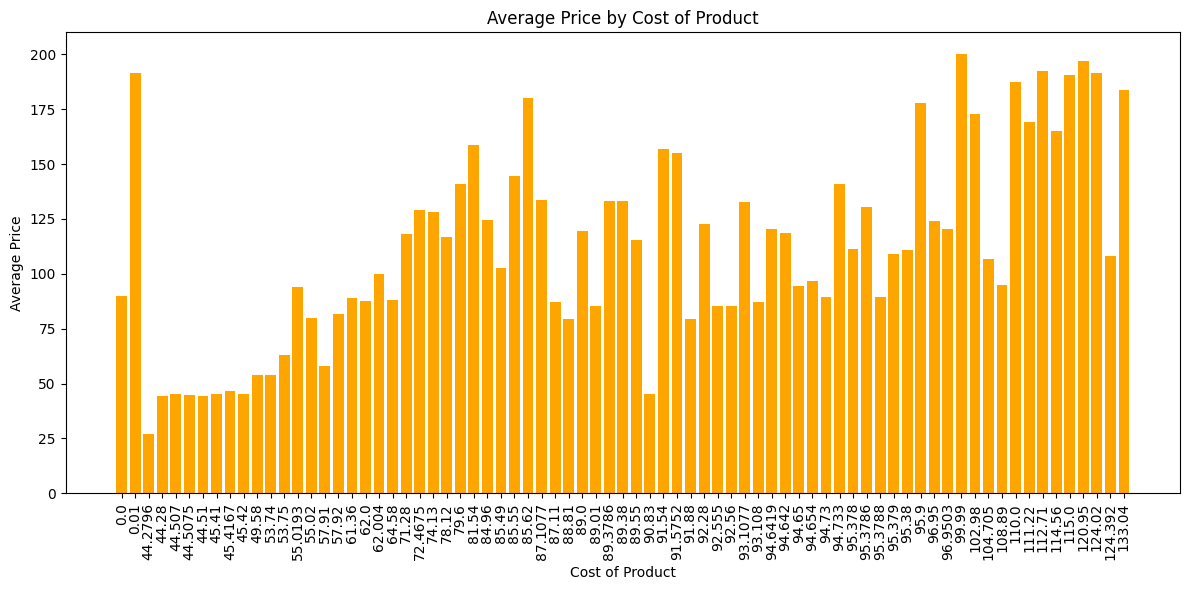

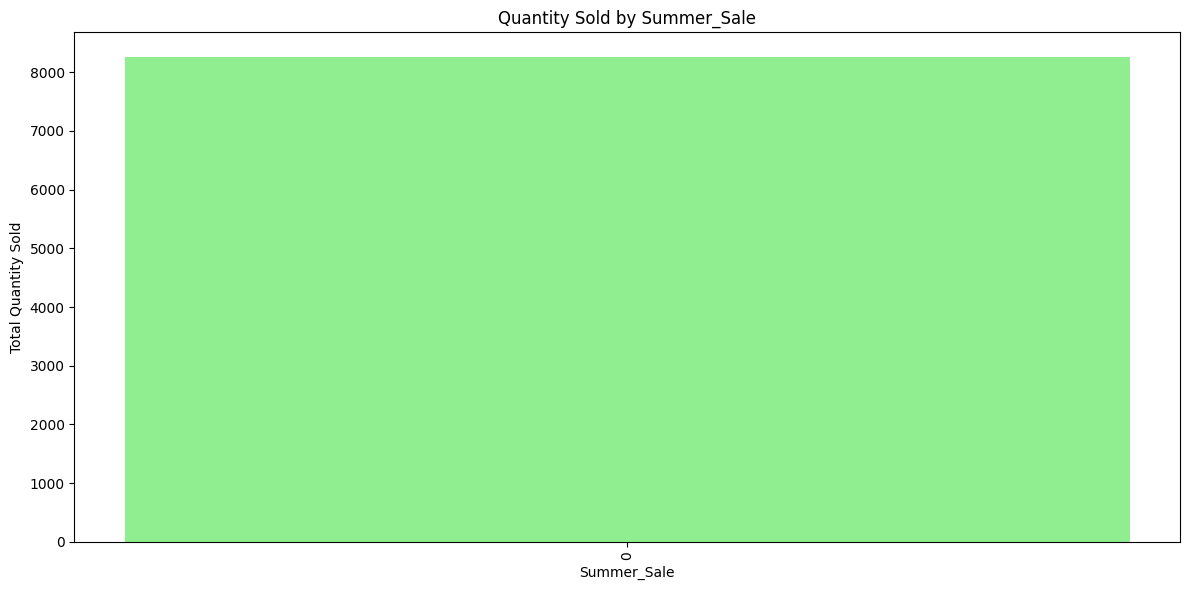

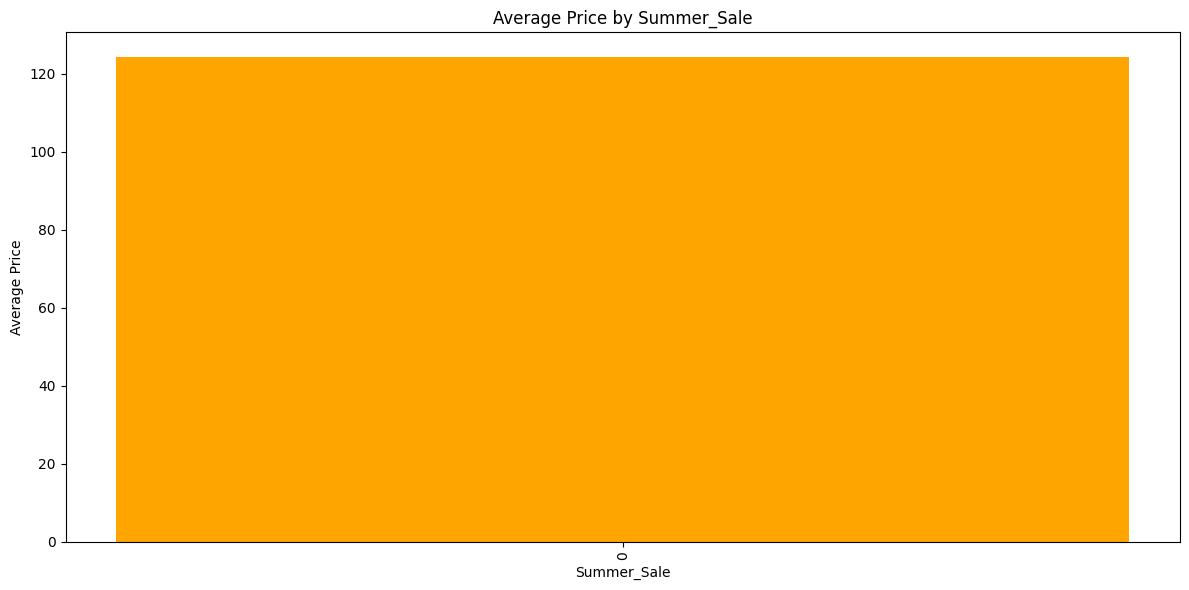

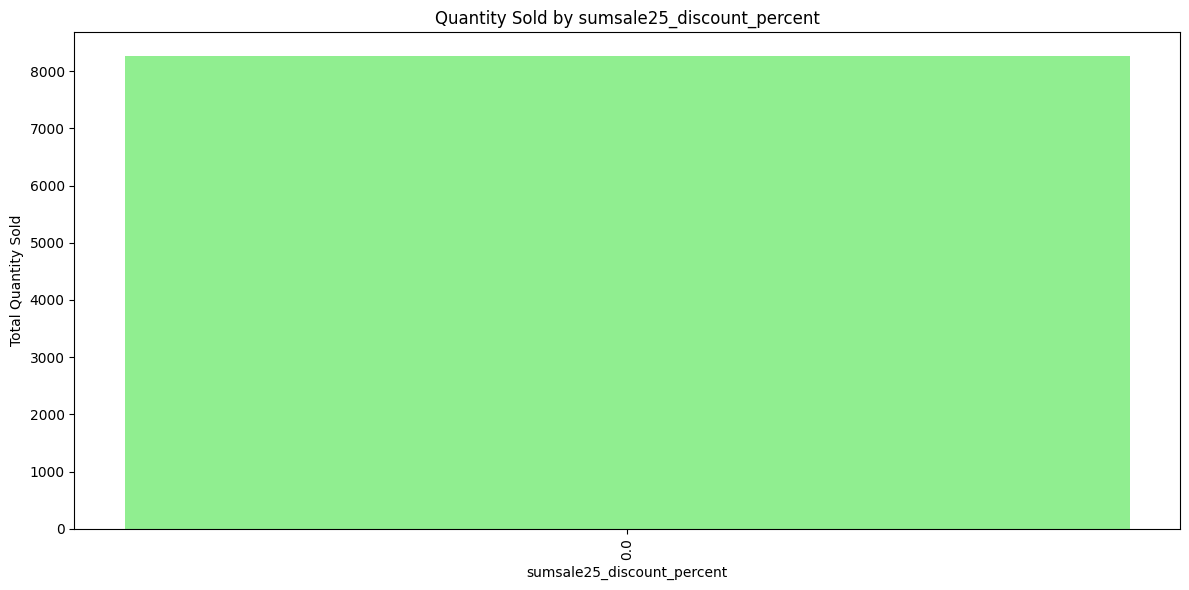

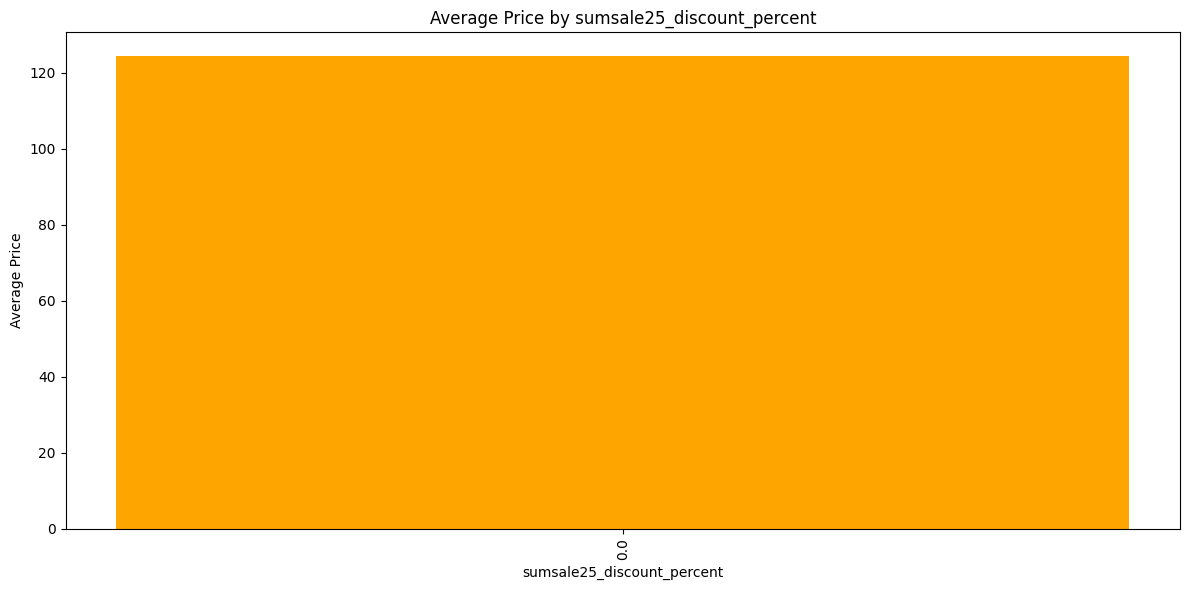

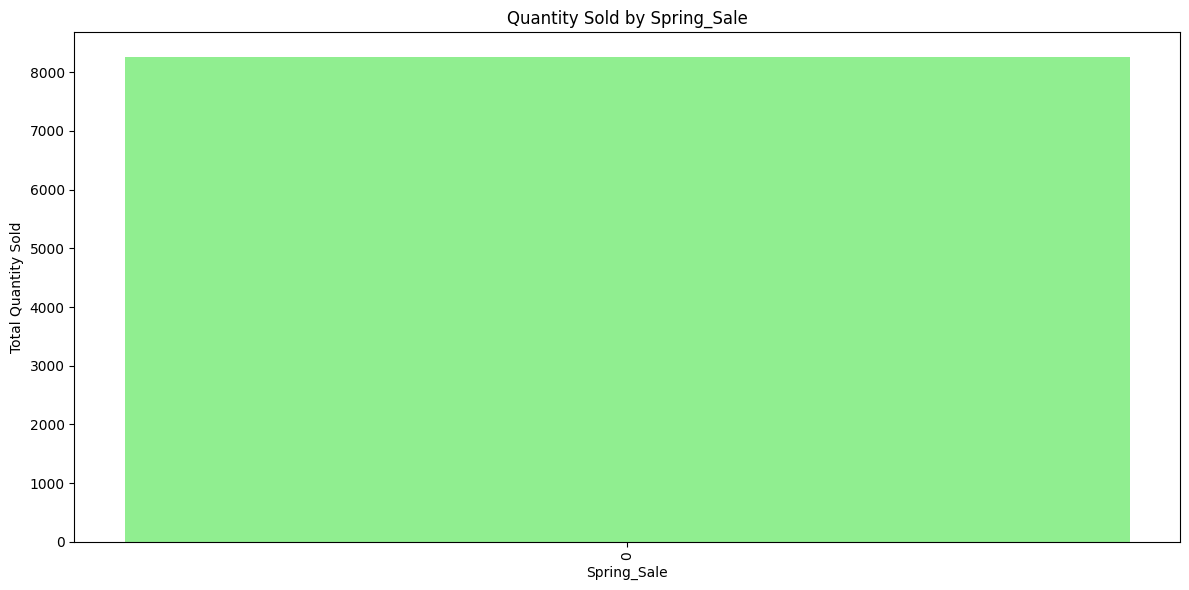

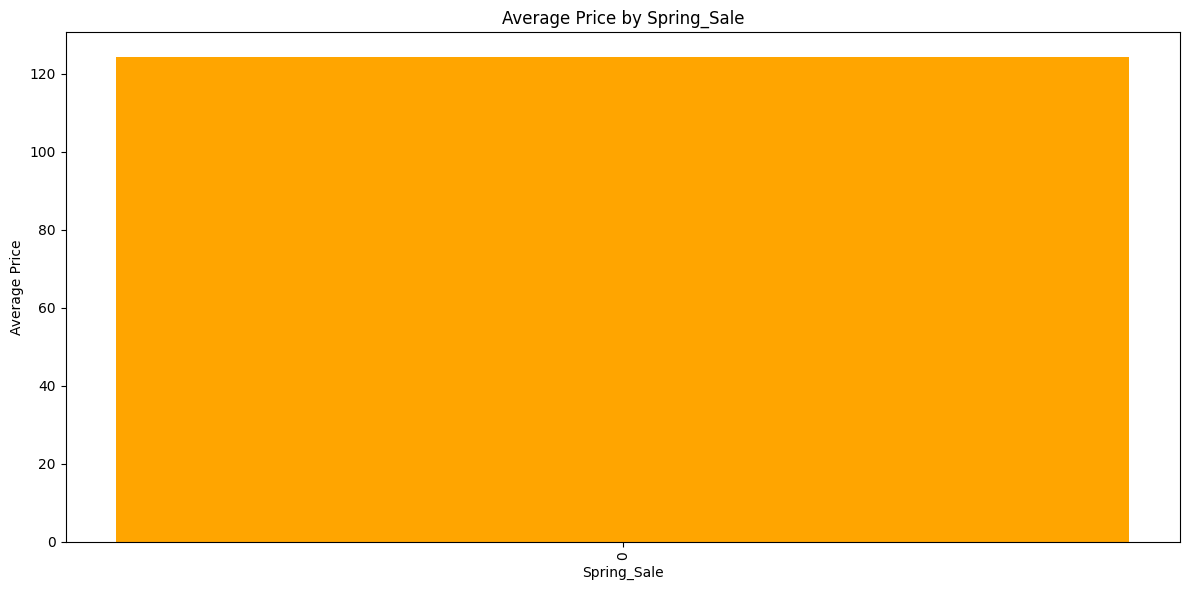

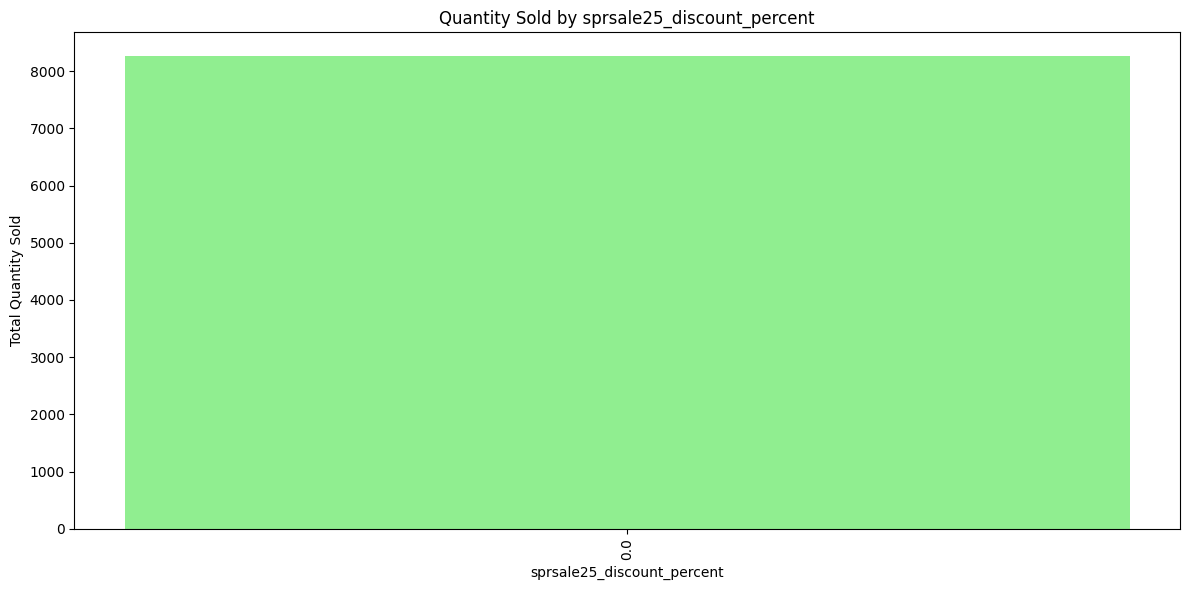

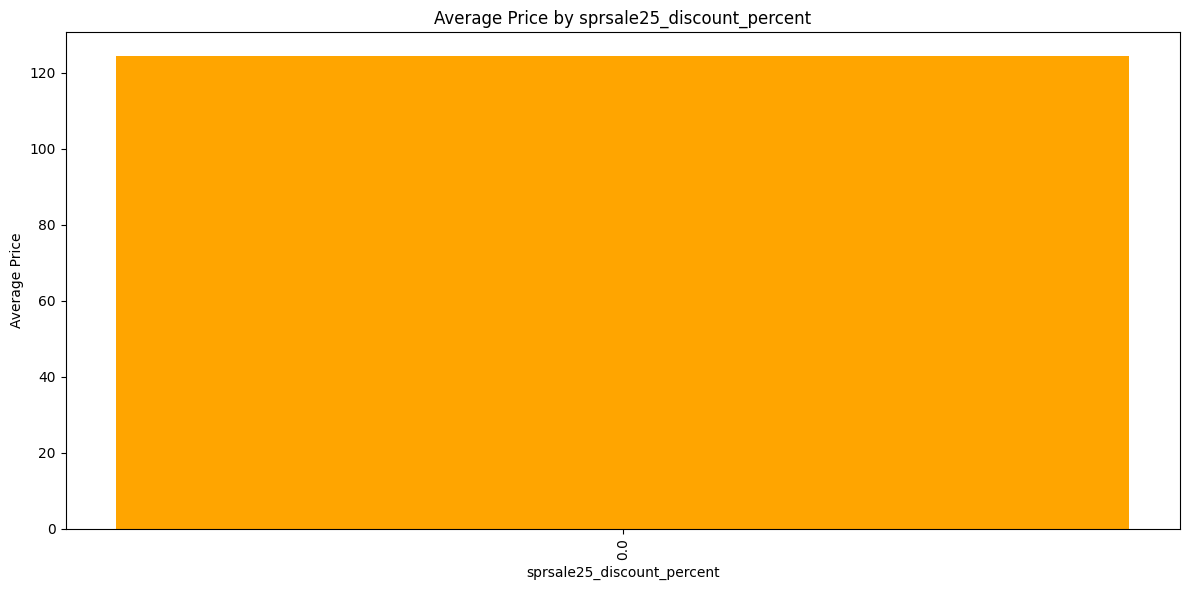

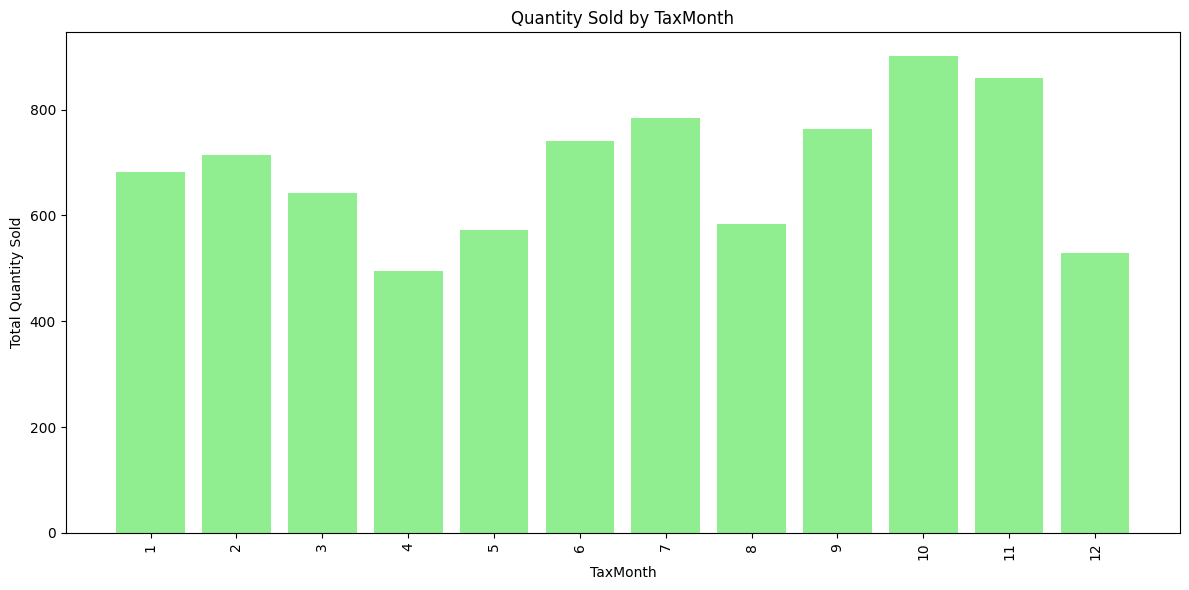

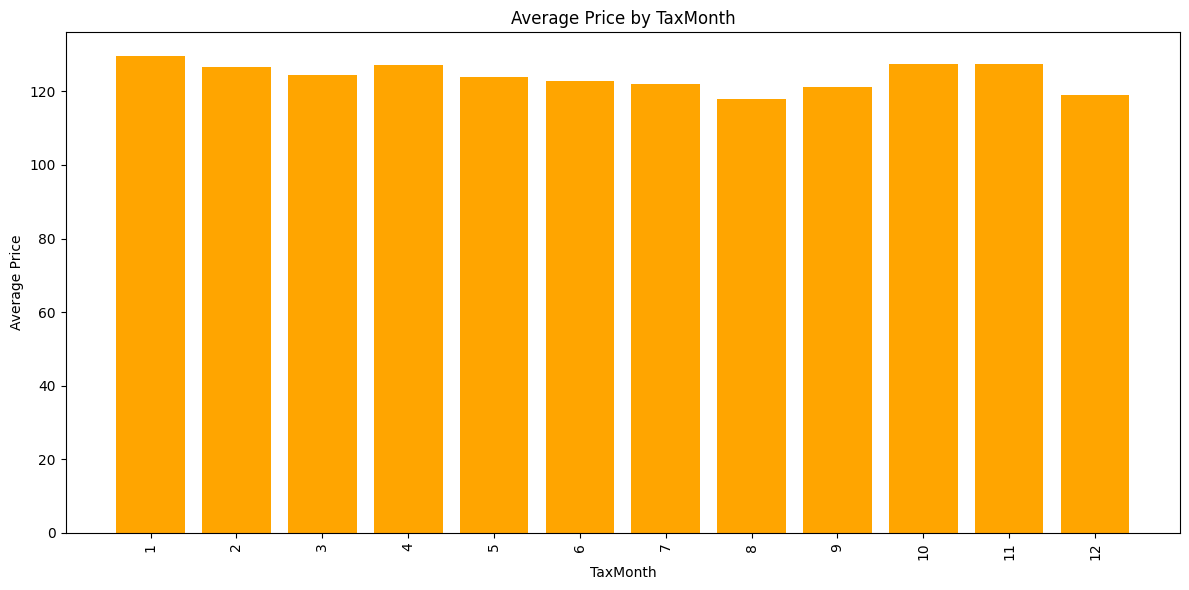

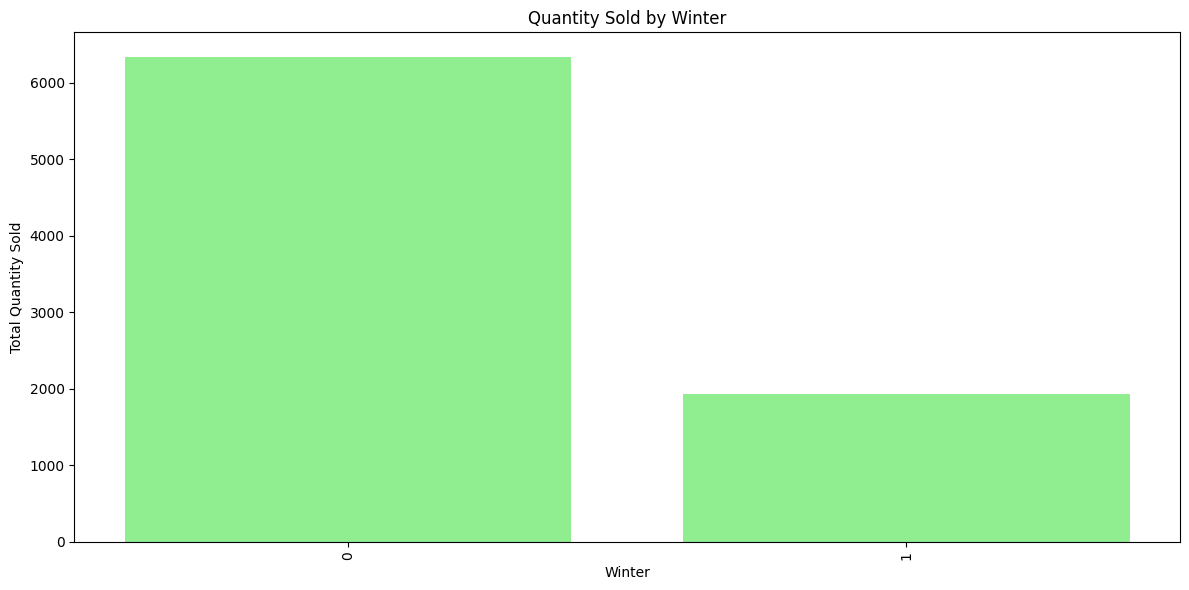

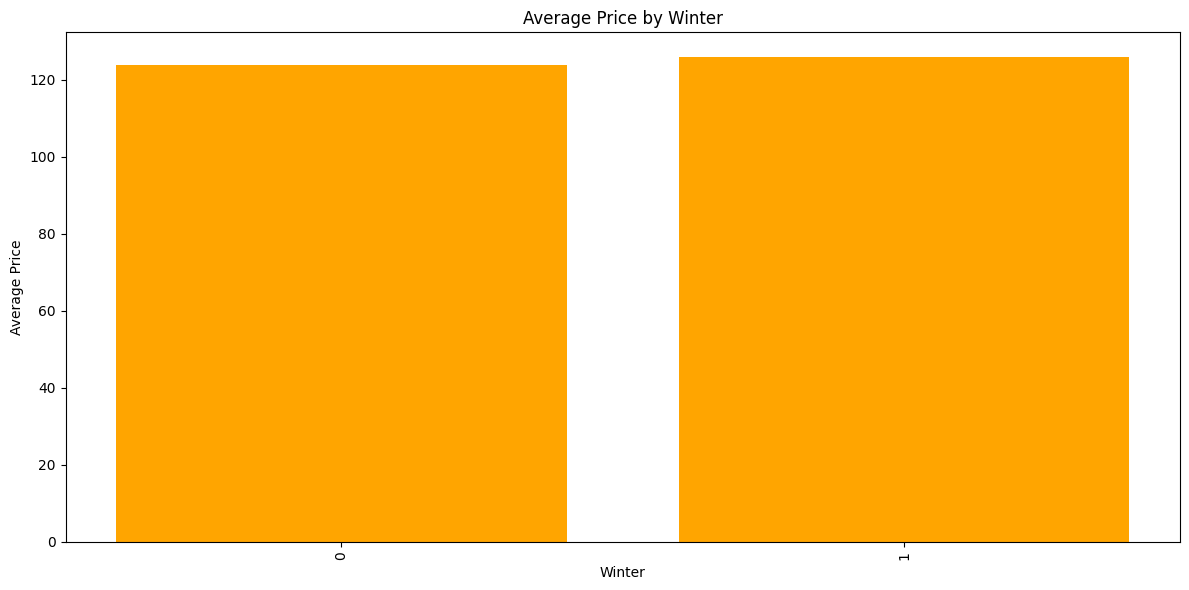

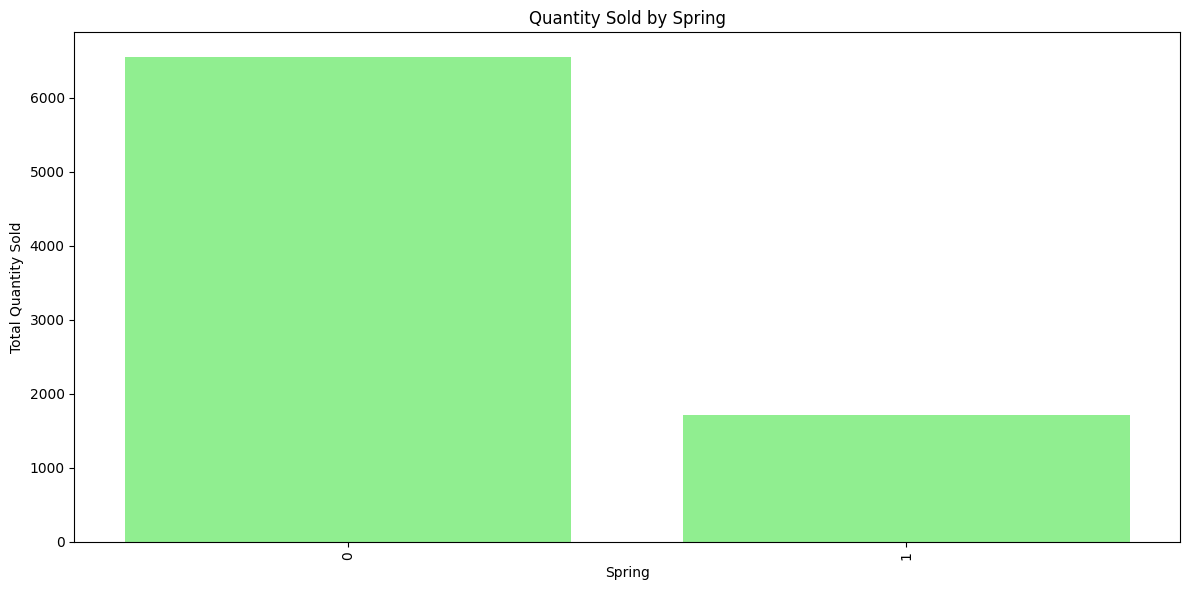

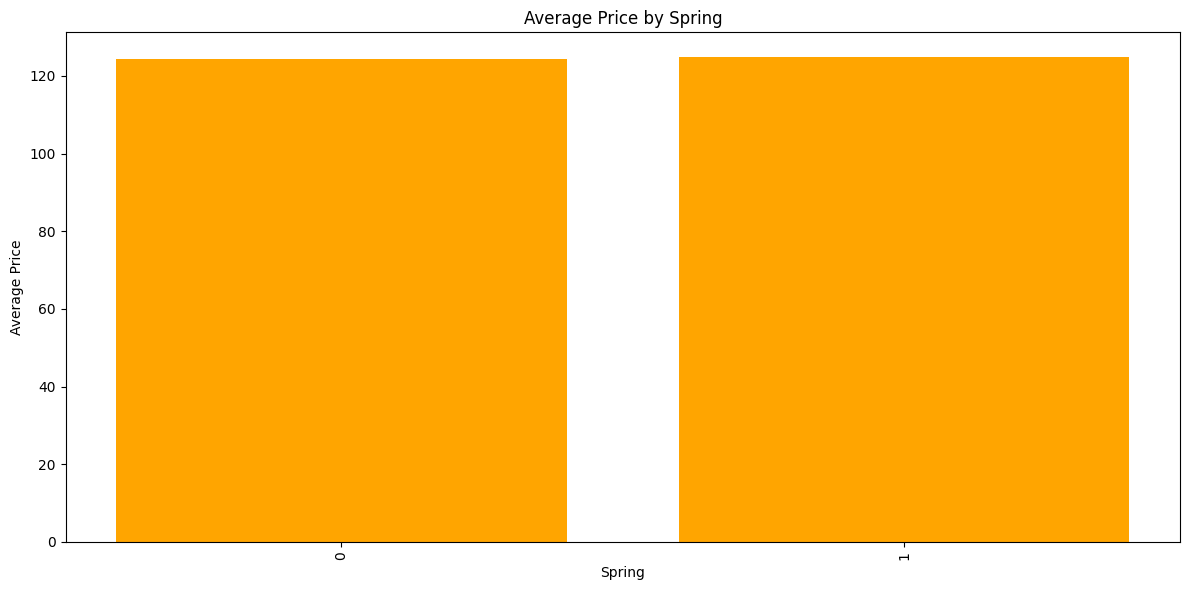

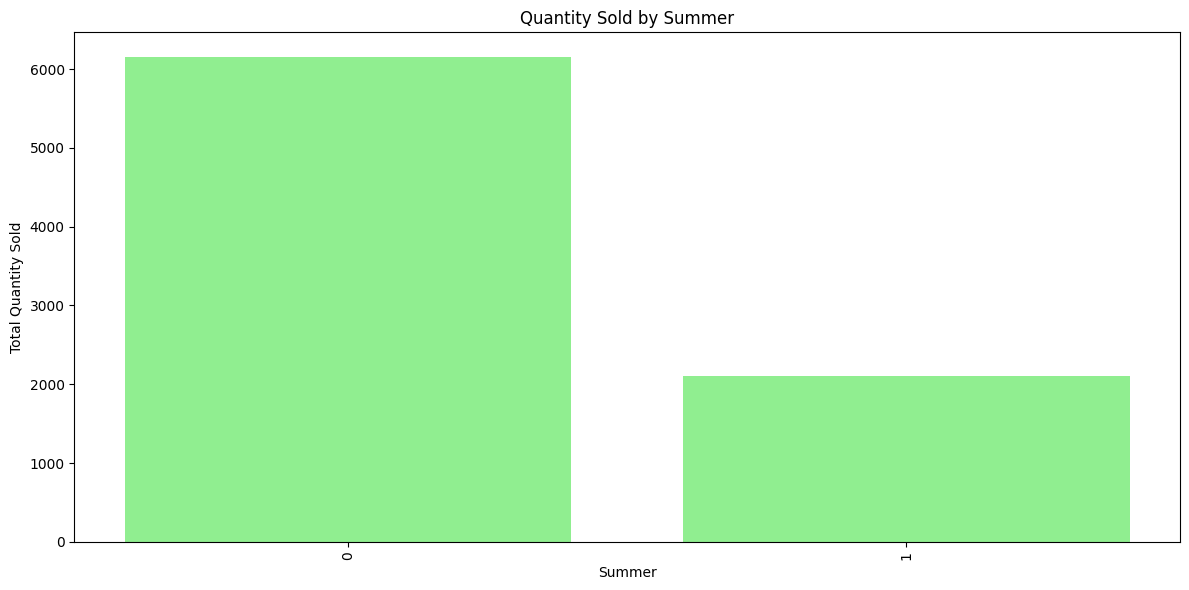

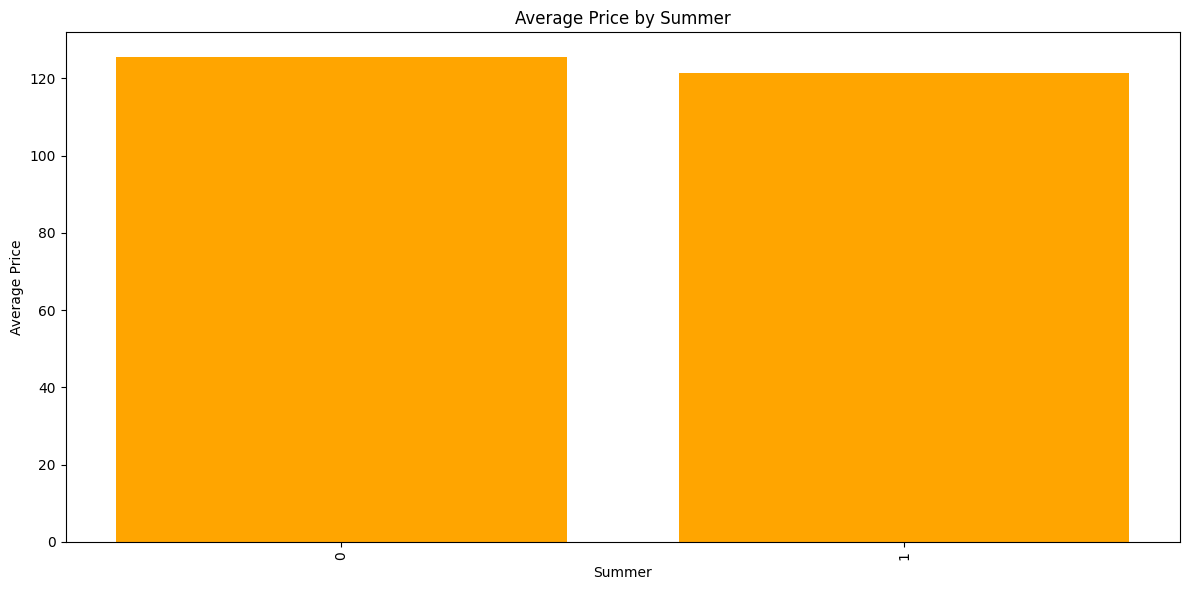

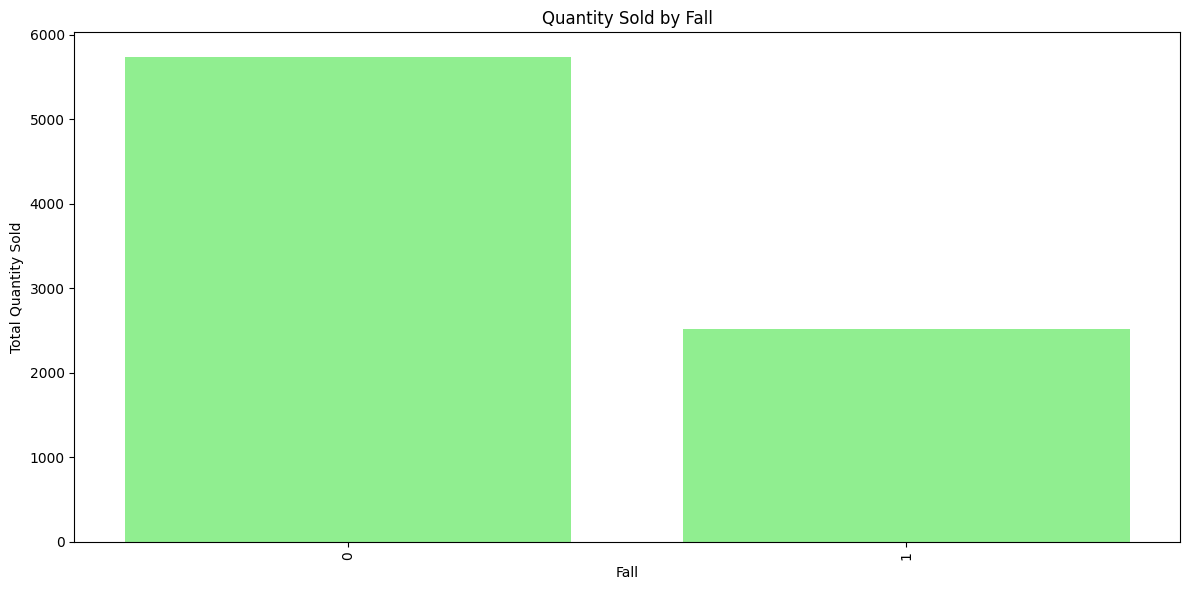

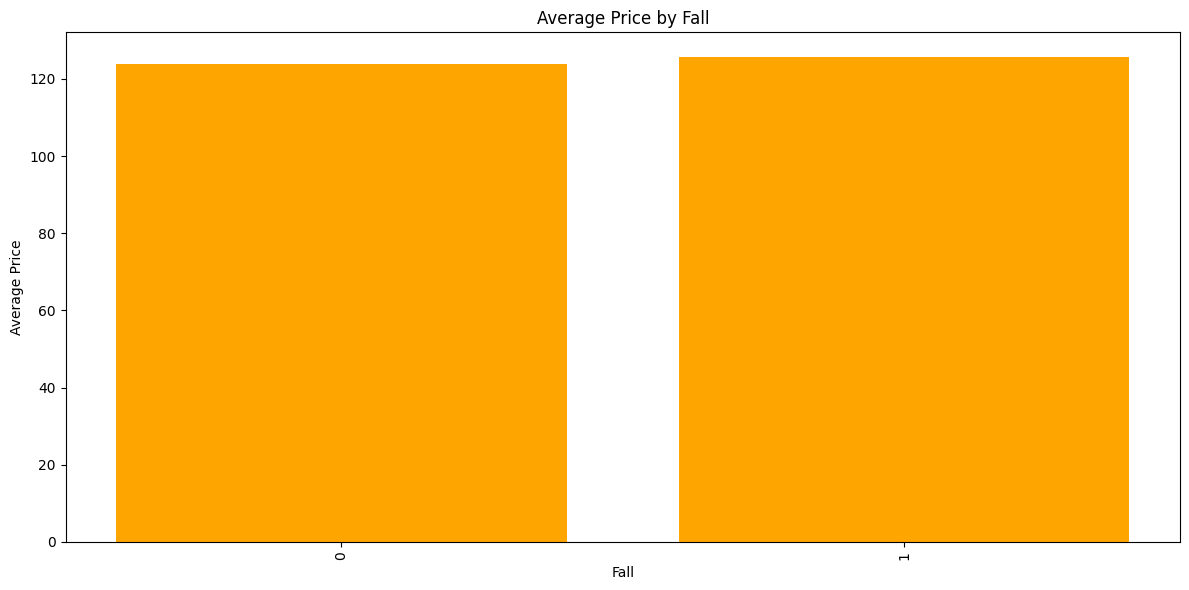

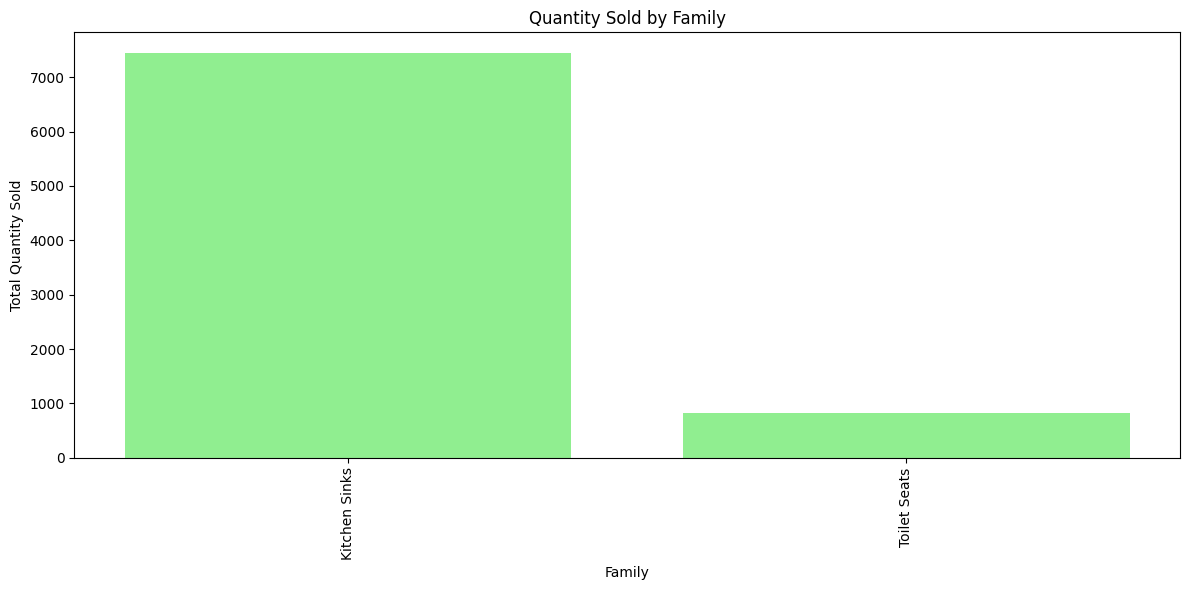

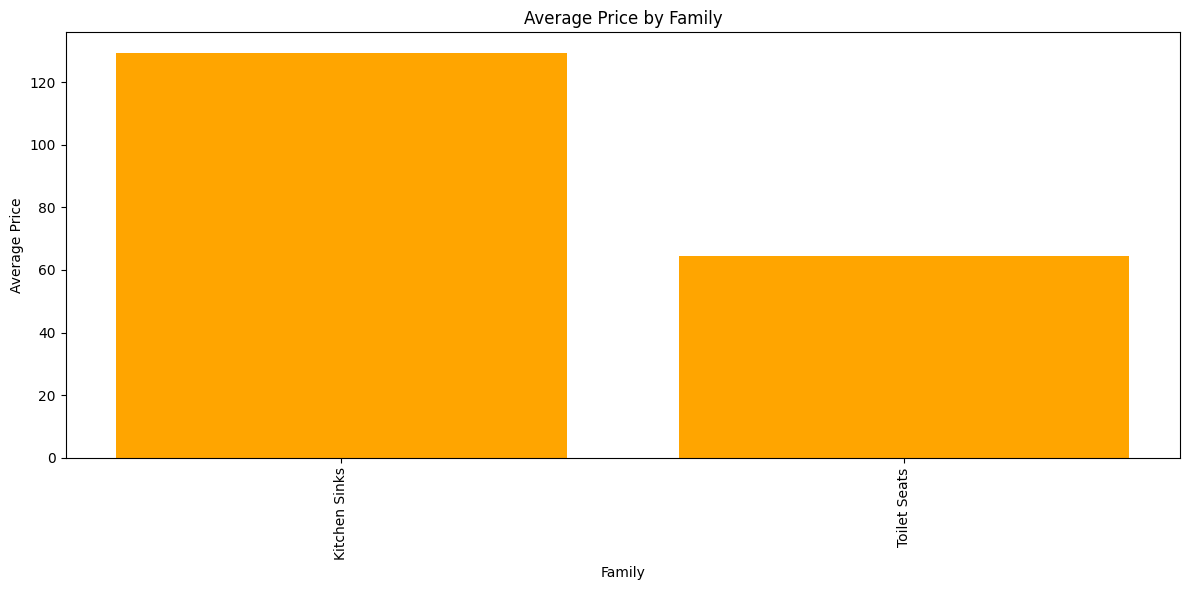

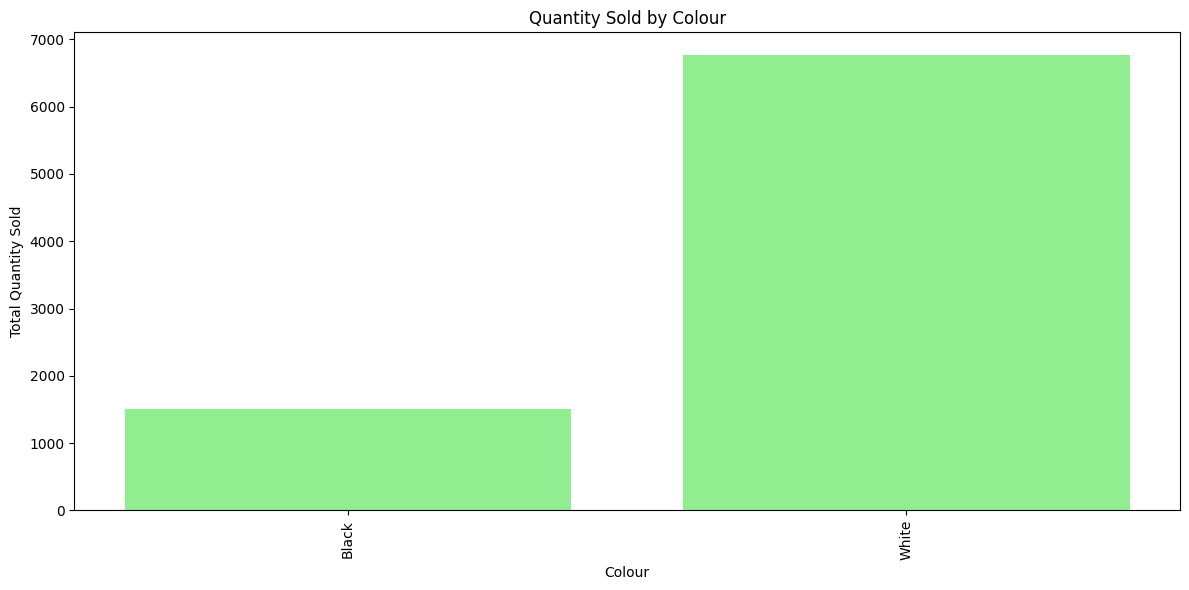

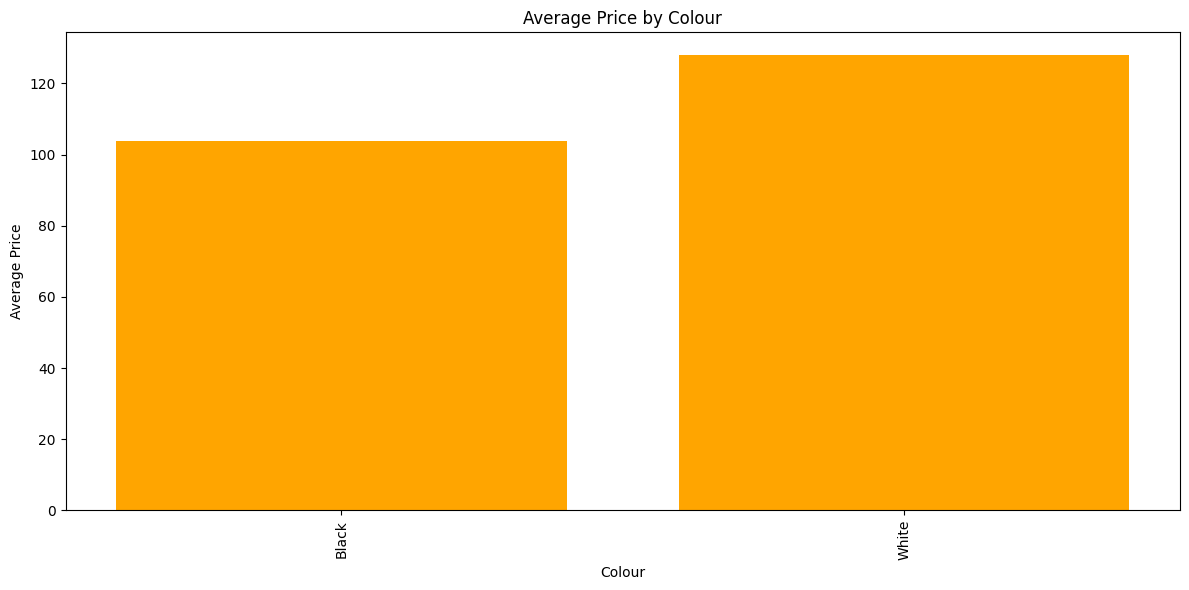

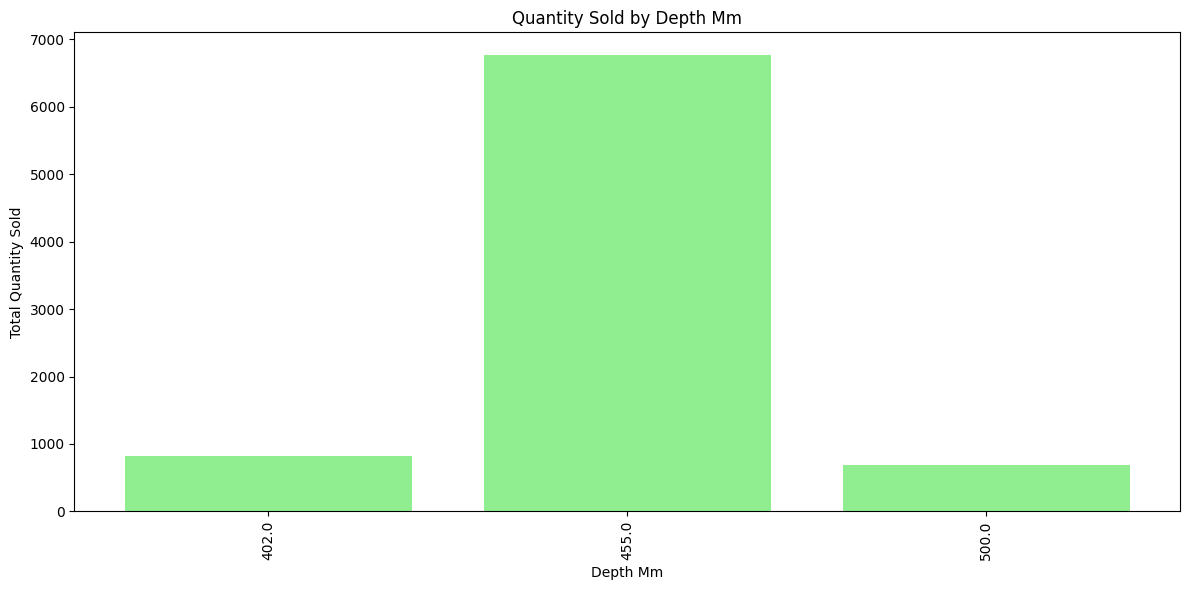

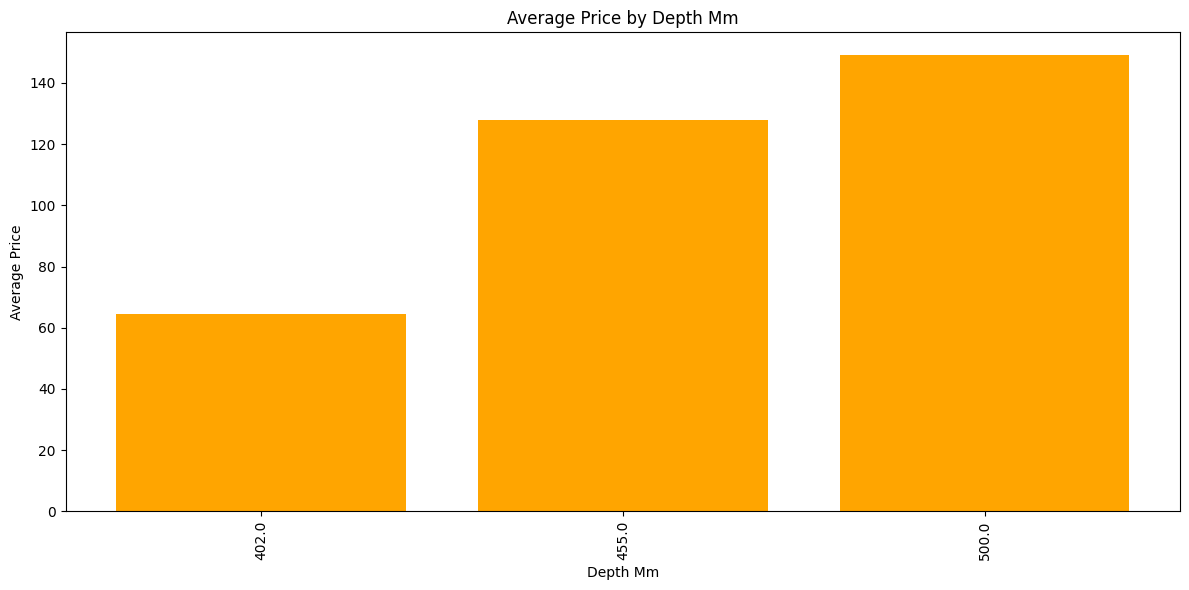

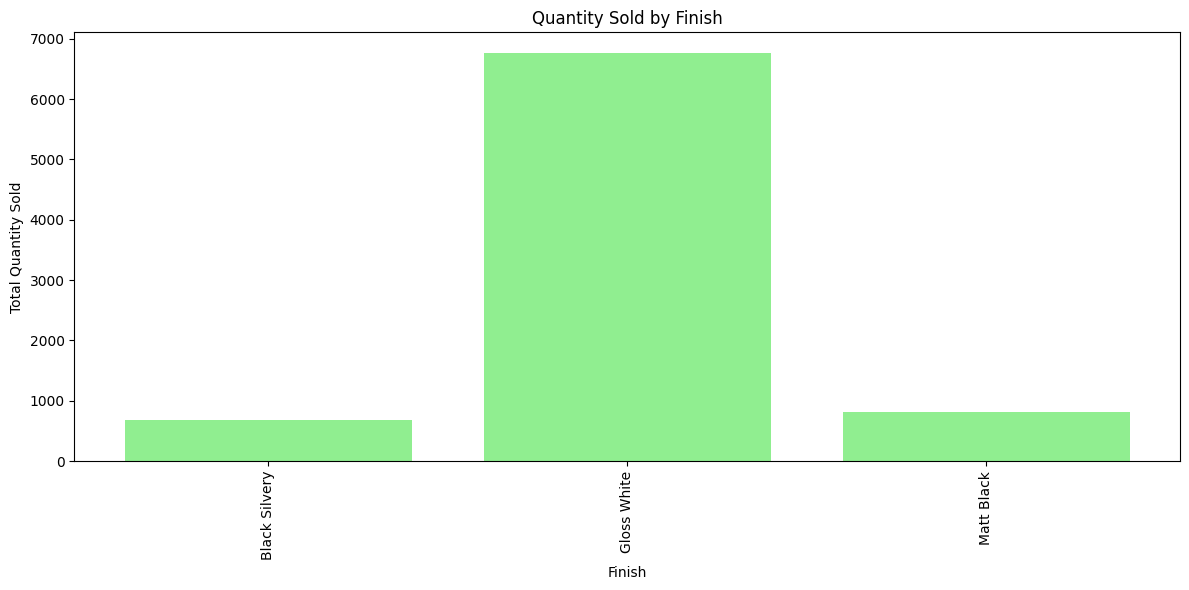

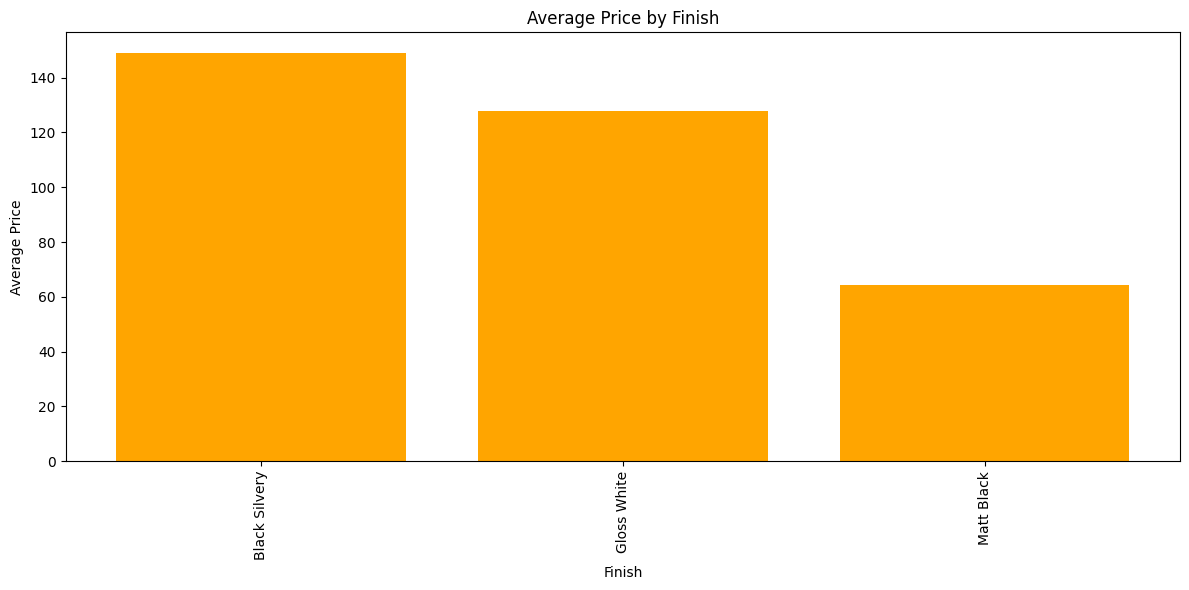

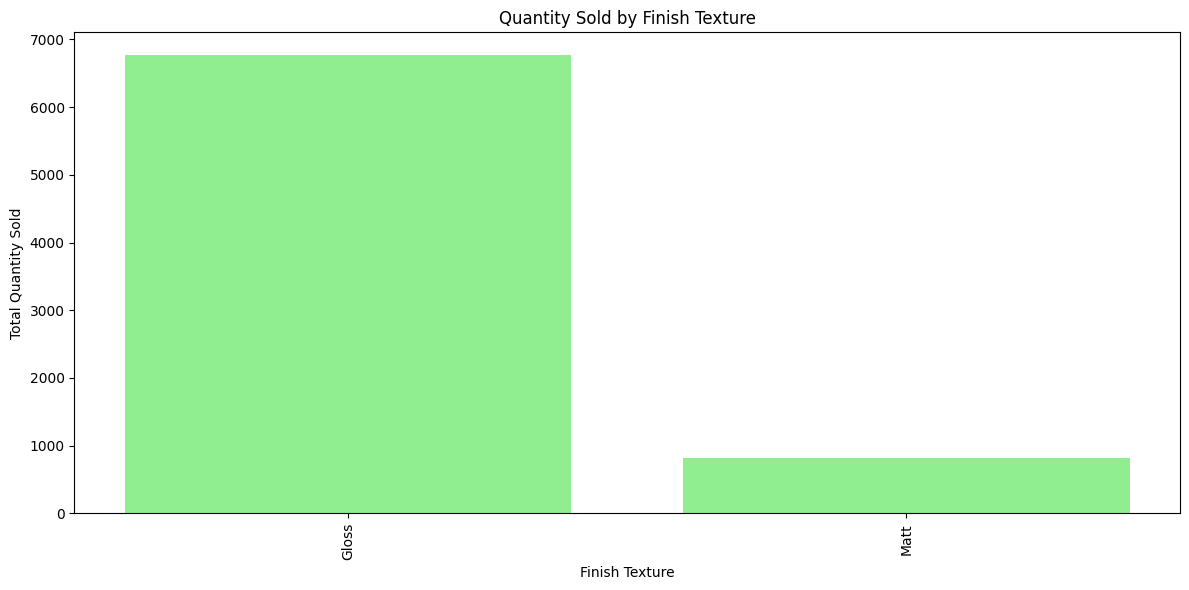

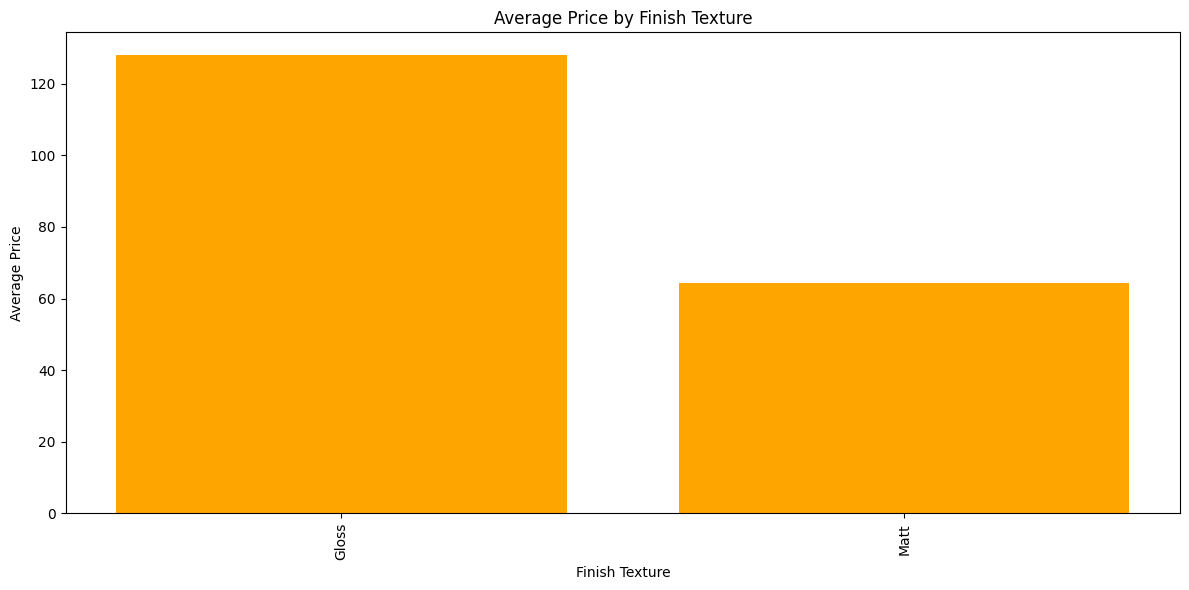

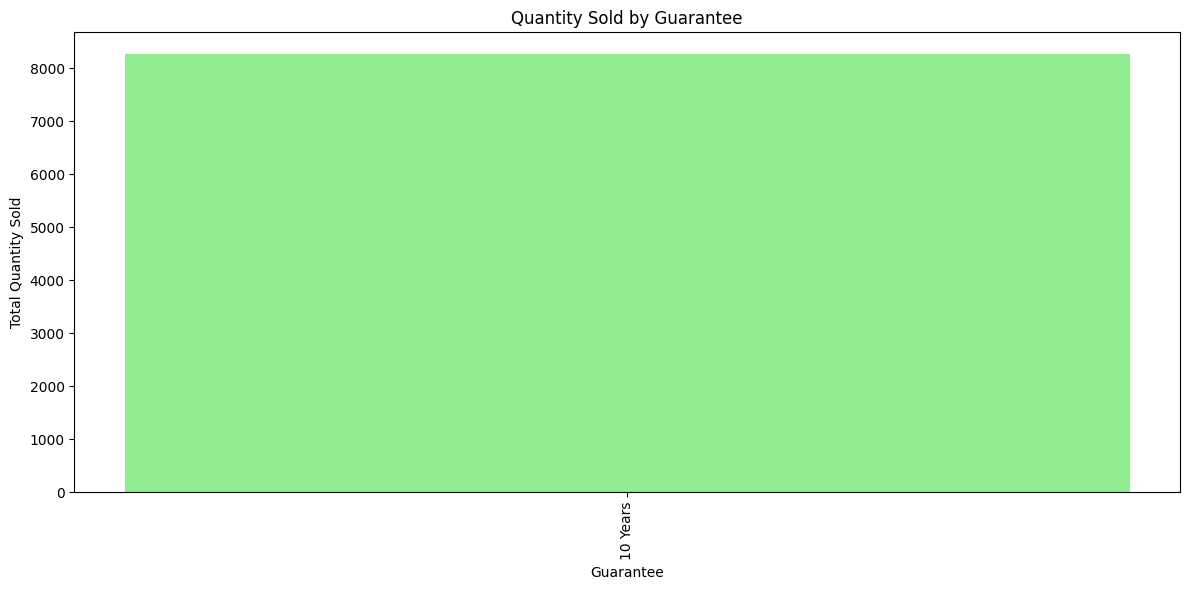

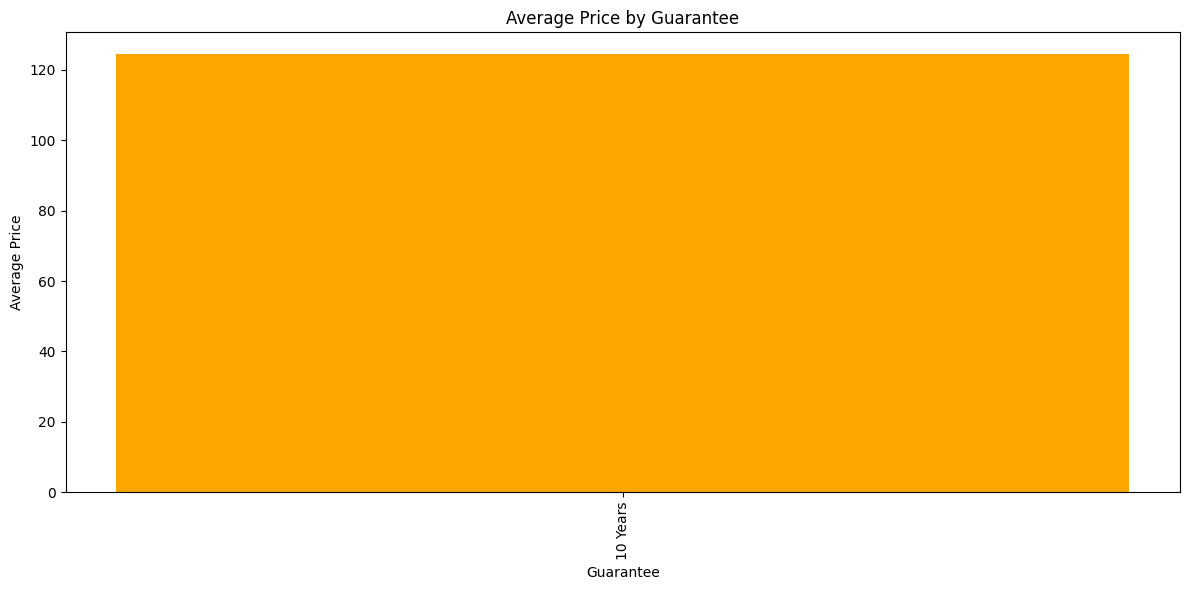

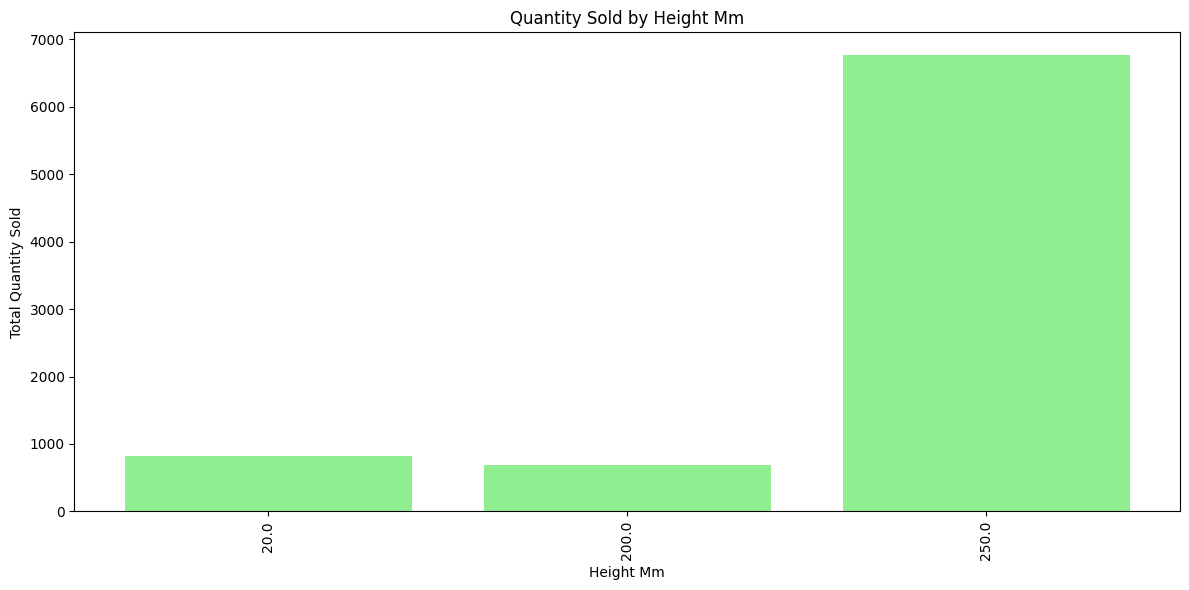

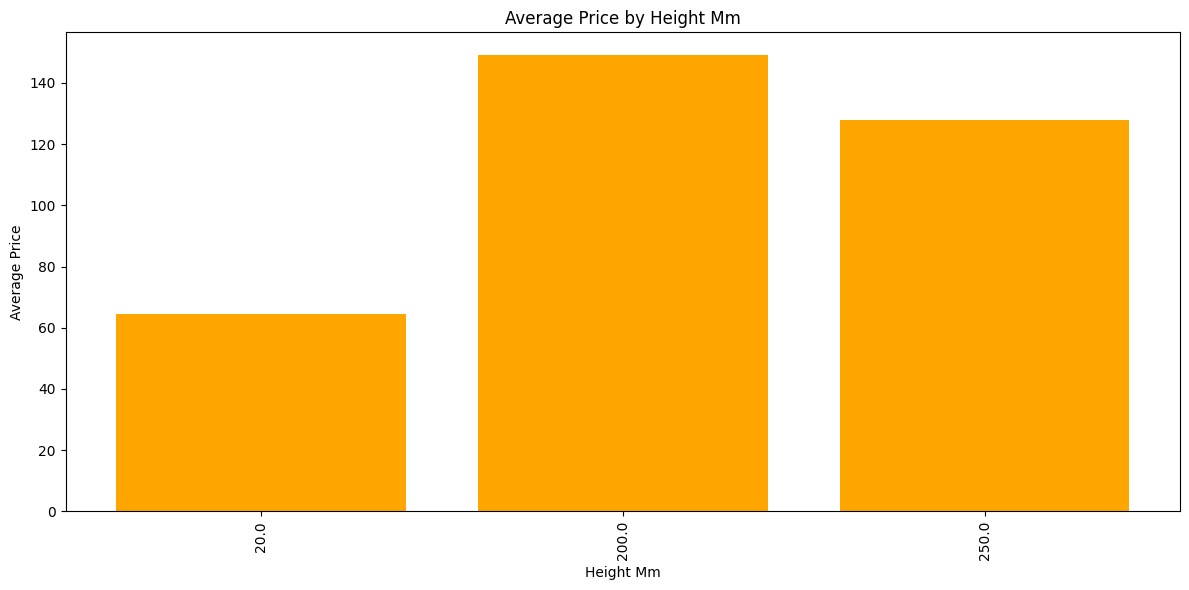

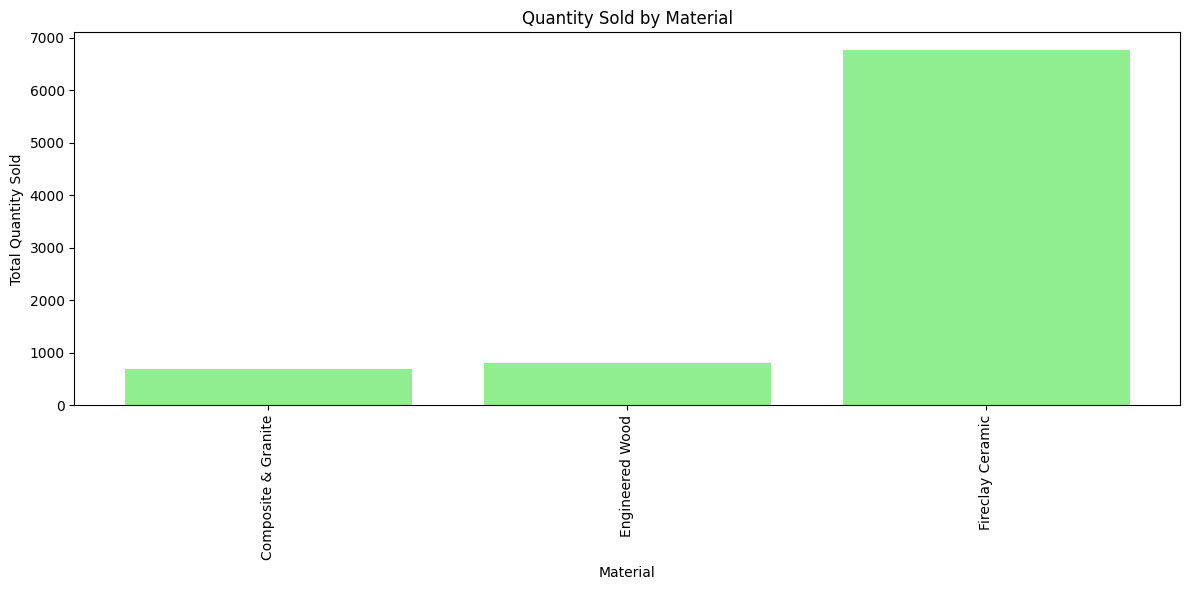

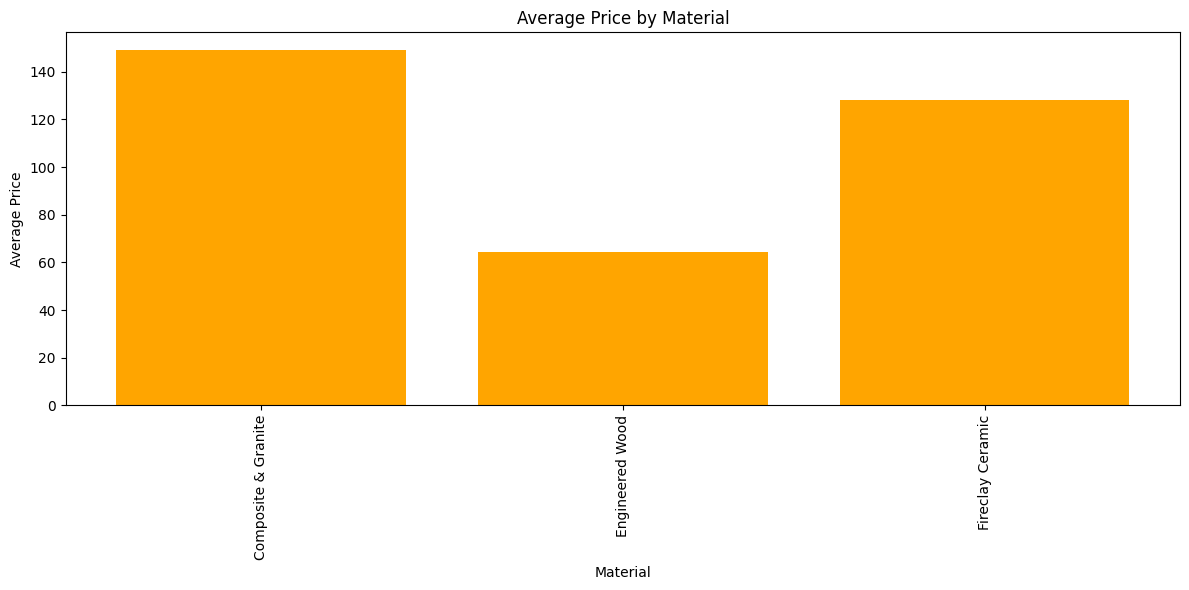

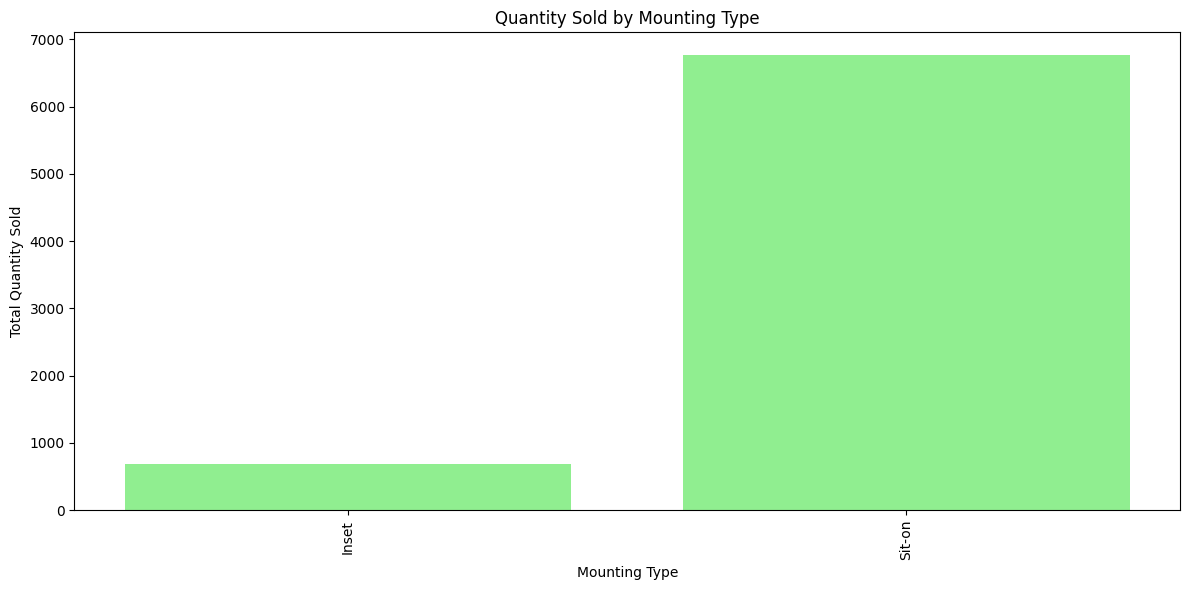

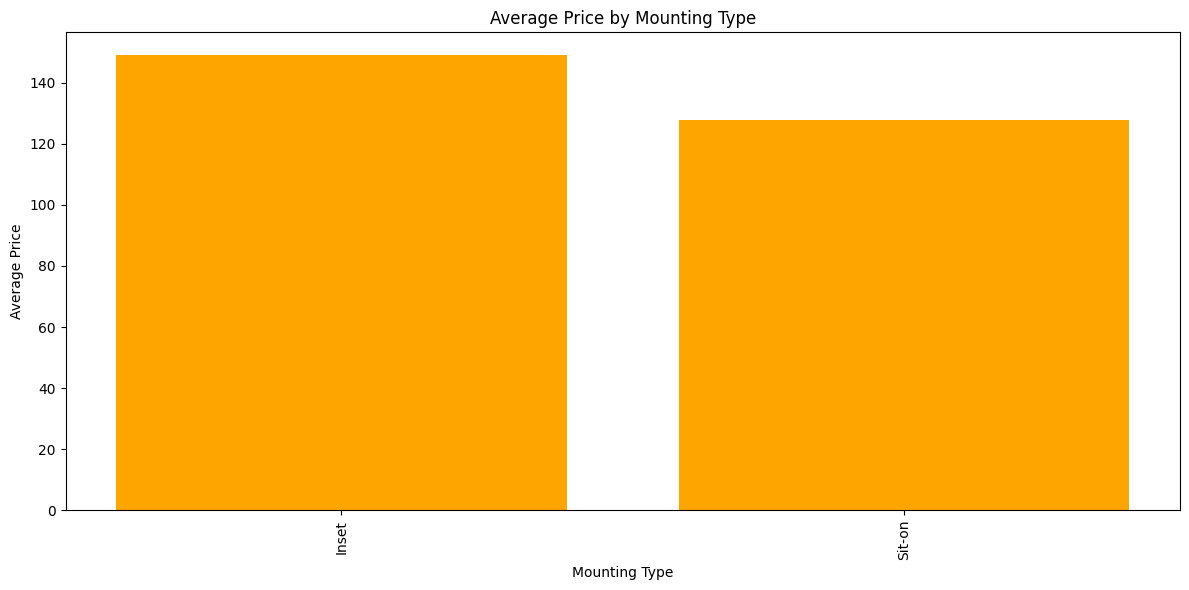

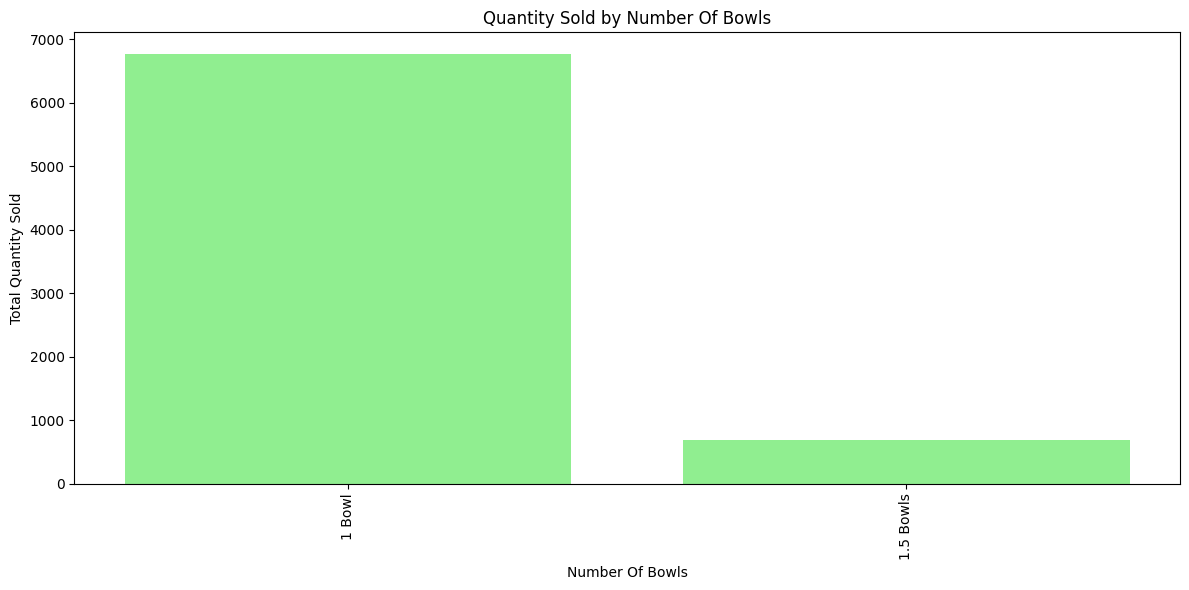

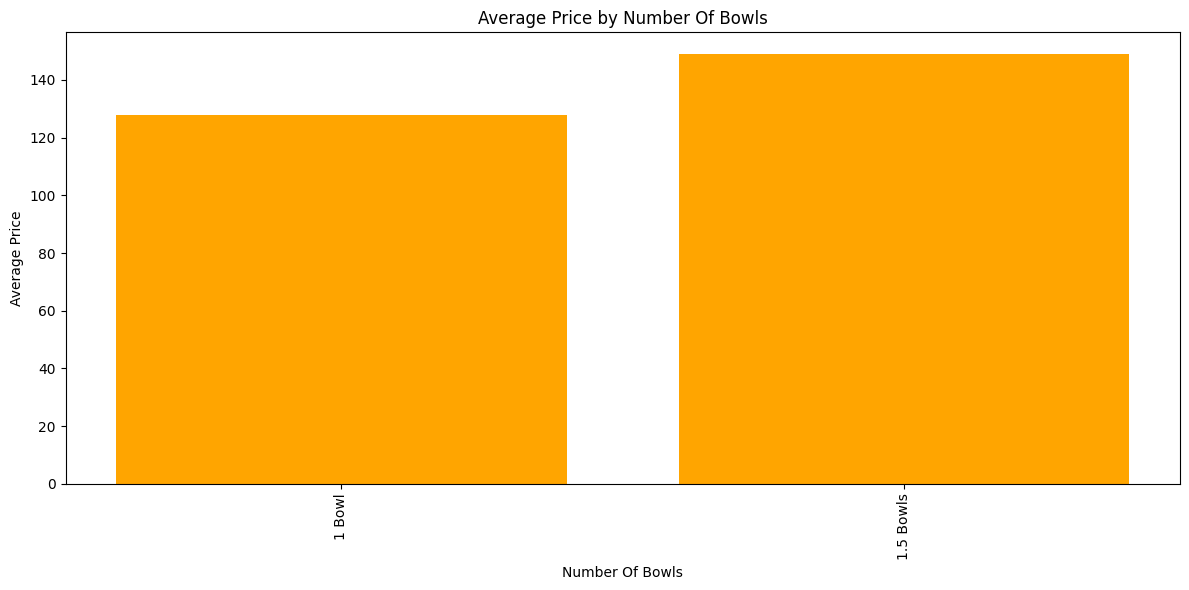

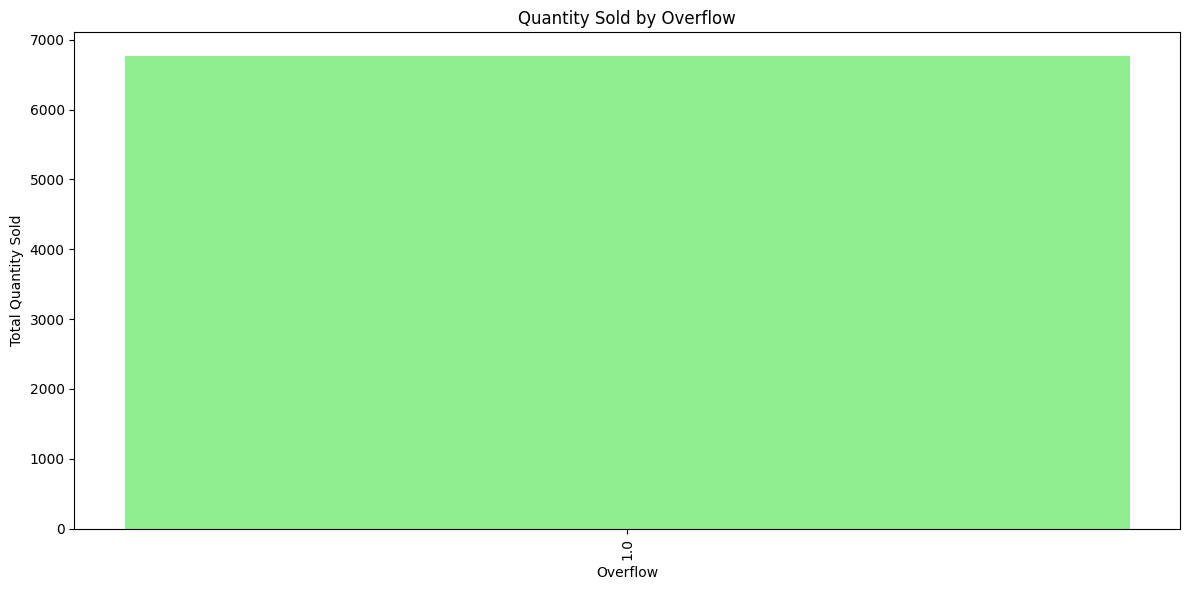

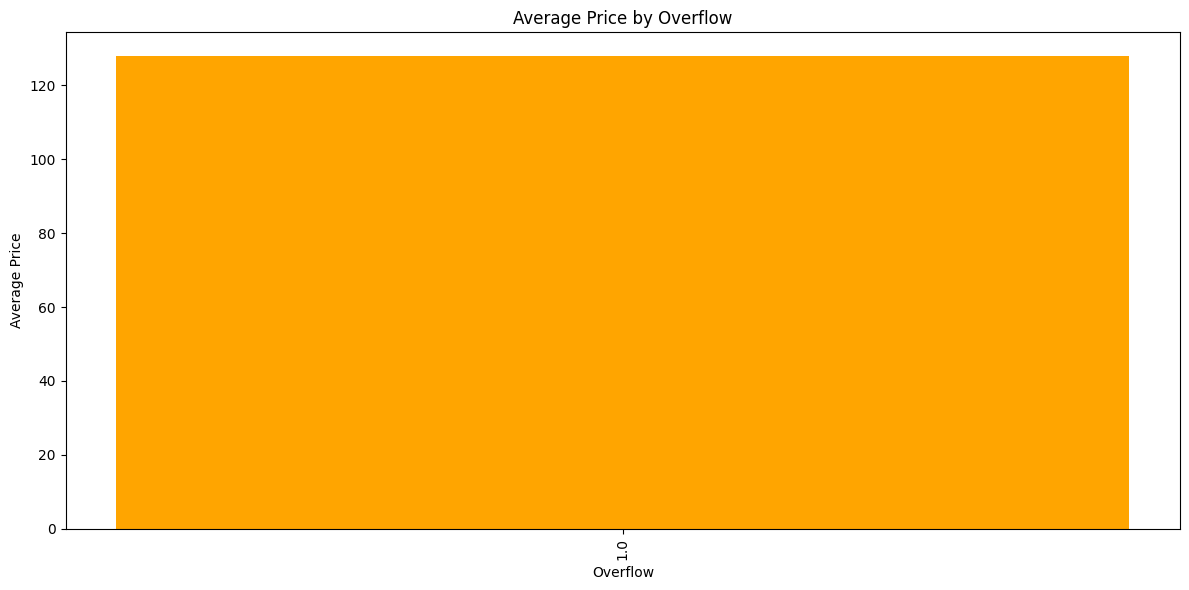

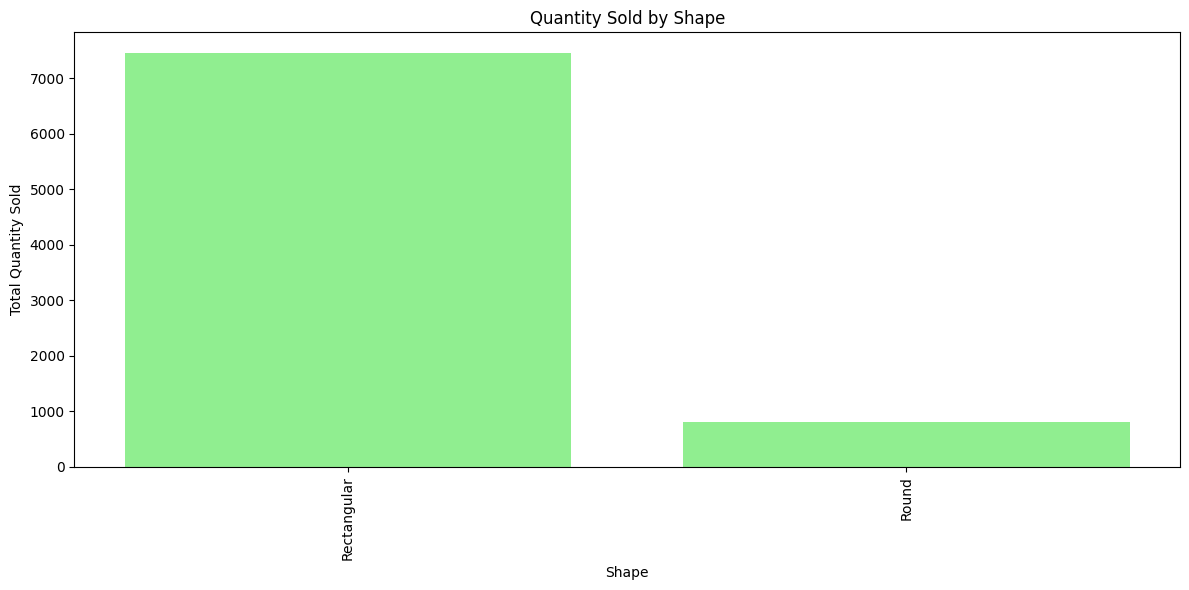

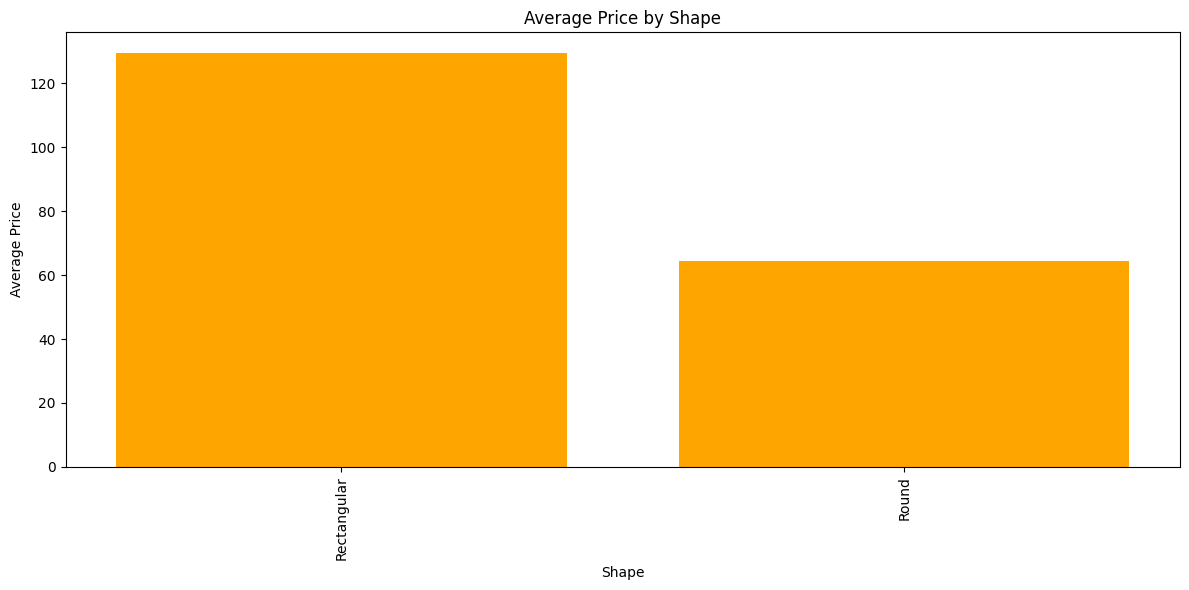

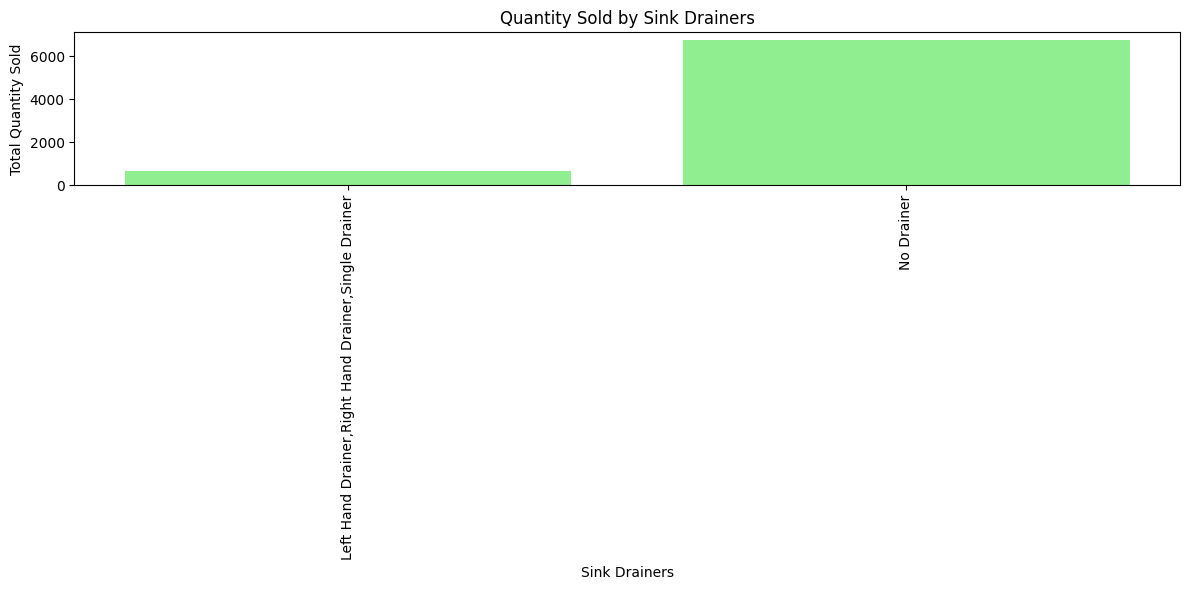

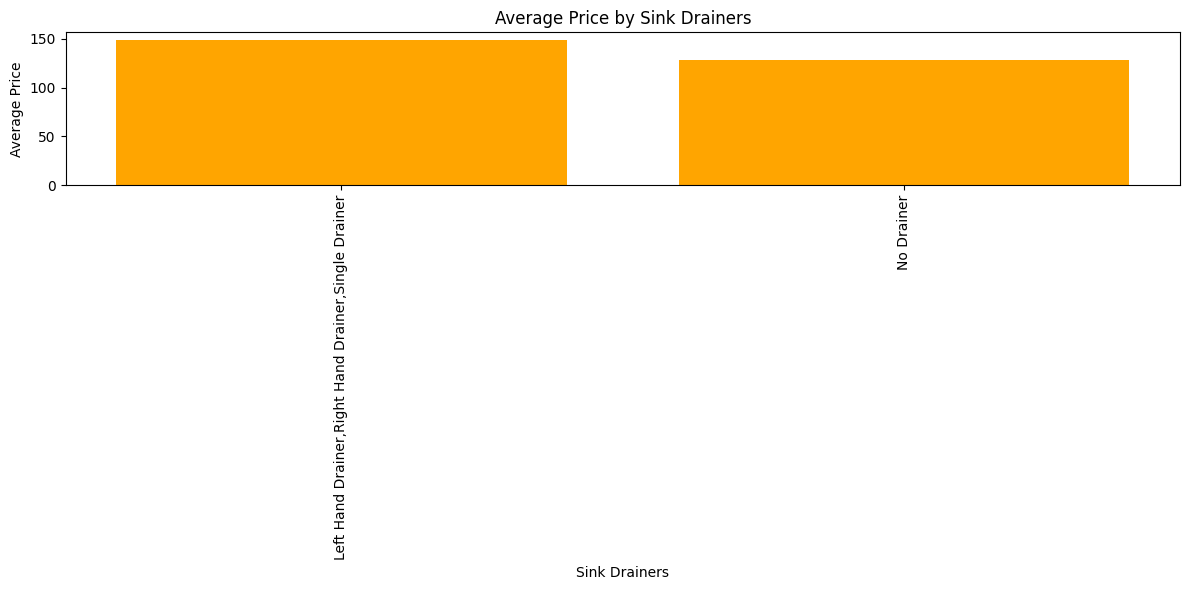

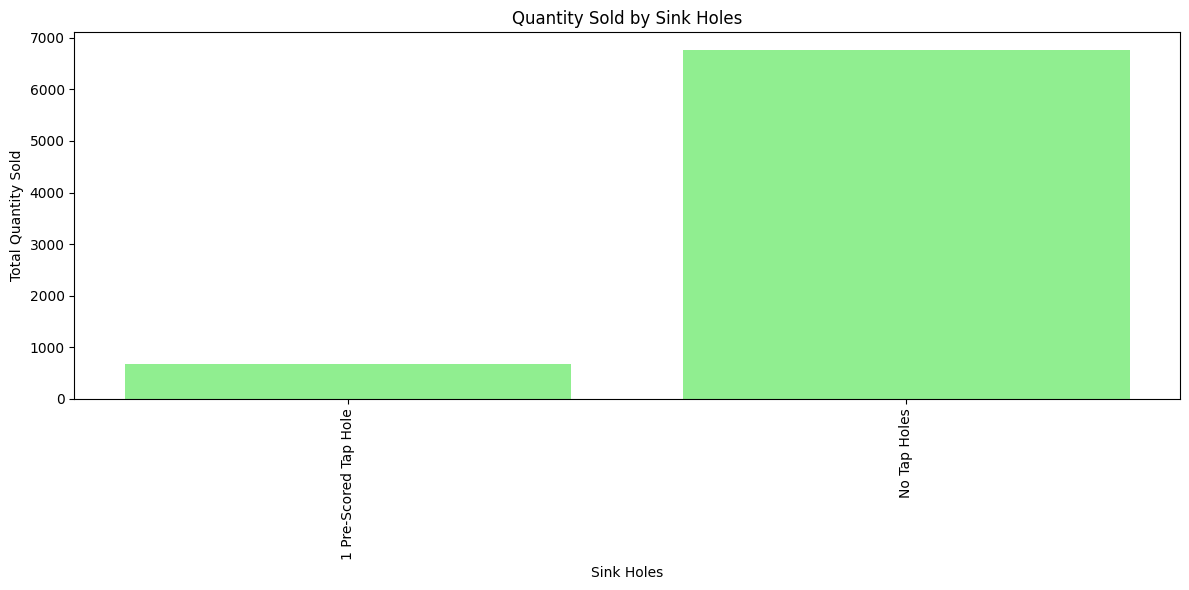

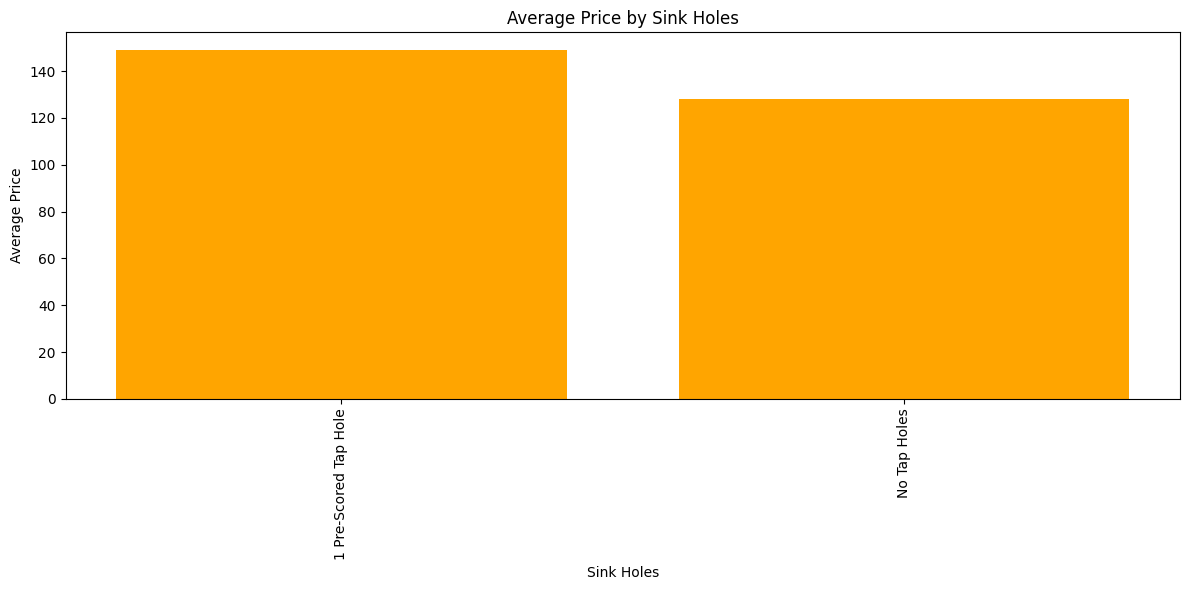

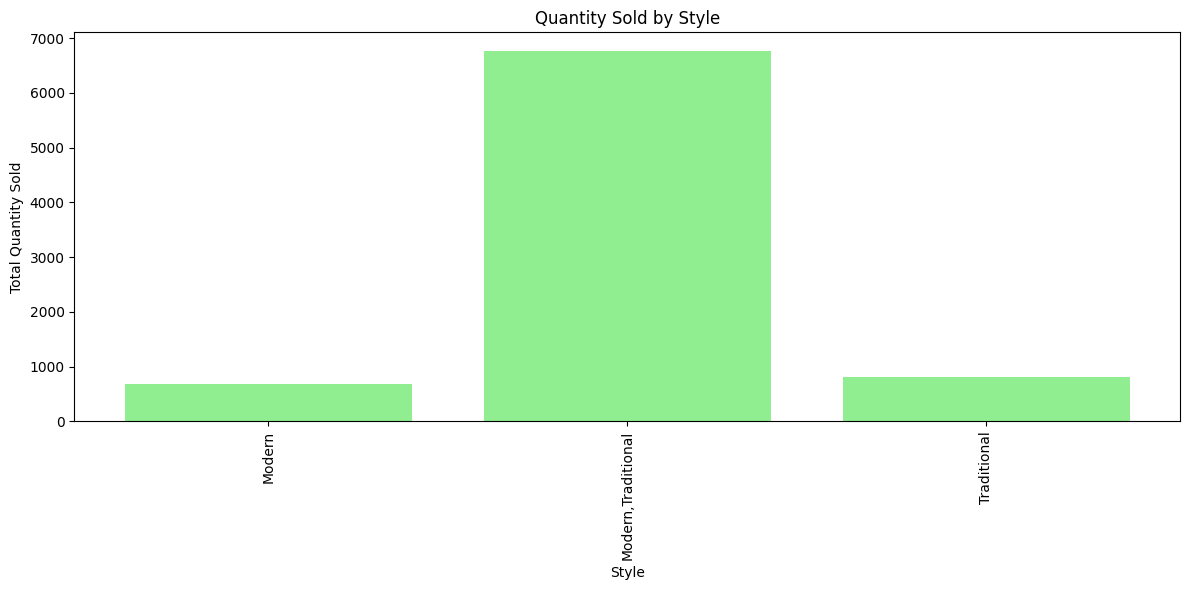

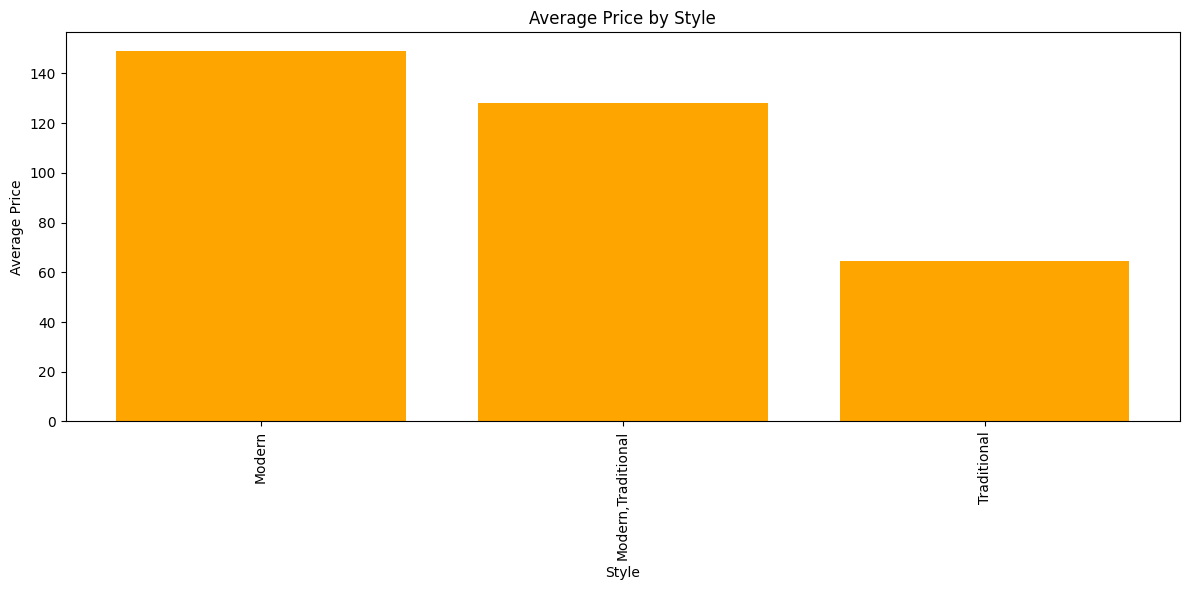

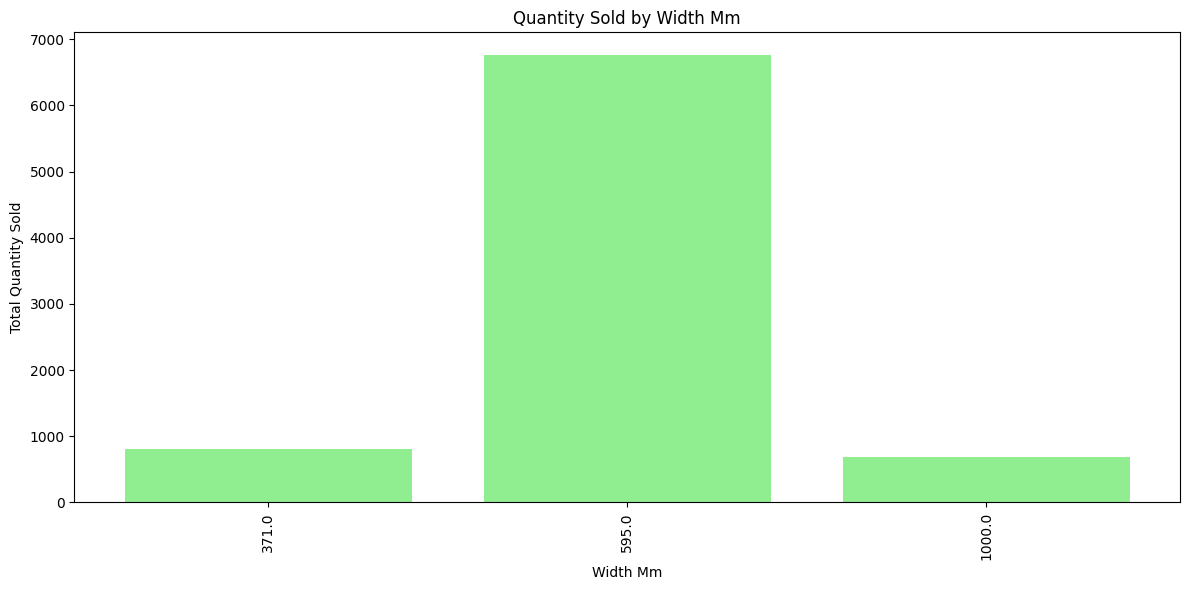

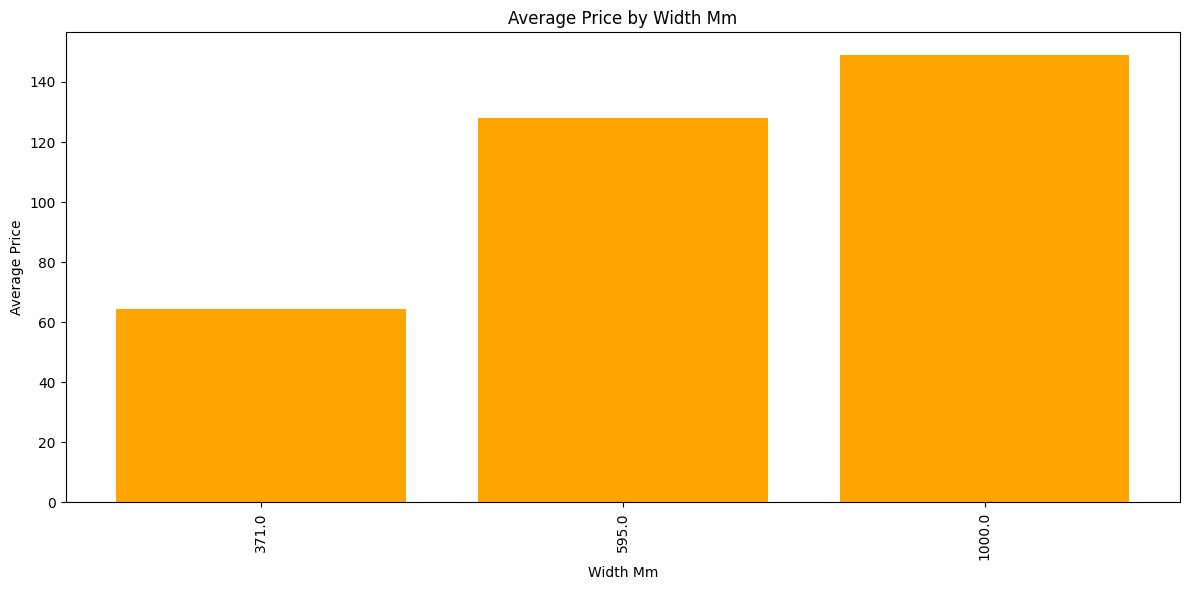

In [17]:
# Product Attributes

# Columns names for easy reference
price_cols = 'Price of Product'
quantity_cols = 'Quantity'
sku_cols = 'SKU'

# Columns to exclude from attributes
exclude_cols = ['Tax Date', 'Order ID', 'Net', 'Total', 'Type Code', 'Orderline ID', 'Product ID', 'Product Name', 'Product Value', 'Product Tax Value',
                'Nominal Code', 'uuid', 'Comp Price 1 - Victoria Plumbing', 'Comp Price 2', 'Comp Price 3']

# Aggregate by SKU
sku_sales = orders.groupby(sku_cols).agg(
    total_quantity=(quantity_cols, 'sum'),
    avg_price=(price_cols, 'mean')
).reset_index()

# Plot SKU vs Quantity
plt.figure(figsize=(12, 6))
plt.bar(sku_sales[sku_cols], sku_sales['total_quantity'], color='skyblue')
plt.xlabel('Product SKU')
plt.ylabel('Total Quantity Sold')
plt.title('Quantity Sold by Product SKU')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot SKU vs Average Price
plt.figure(figsize=(12, 6))
plt.bar(sku_sales[sku_cols], sku_sales['avg_price'], color='salmon')
plt.xlabel('Product SKU')
plt.ylabel('Average Price')
plt.title('Average Price by Product SKU')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# for eacch attribute
attribute_columns = [col for col in orders.columns if col not in [price_cols, quantity_cols, sku_cols] + exclude_cols]

for attr in attribute_columns:
    attr_sales = orders.groupby(attr).agg(
        total_quantity=(quantity_cols, 'sum'),
        avg_price=(price_cols, 'mean')
    ).reset_index()

    # Plot Attribute vs Quantity
    plt.figure(figsize=(12, 6))
    plt.bar(attr_sales[attr].astype(str), attr_sales['total_quantity'], color='lightgreen')
    plt.xlabel(attr)
    plt.ylabel('Total Quantity Sold')
    plt.title(f'Quantity Sold by {attr}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    # Uncomment when needed
    #plt.show()

    #plot Attribute vs Average Price
    plt.figure(figsize=(12, 6))
    plt.bar(attr_sales[attr].astype(str), attr_sales['avg_price'], color='orange')
    plt.xlabel(attr)
    plt.ylabel('Average Price')
    plt.title(f'Average Price by {attr}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    # Uncomment when needed
    #plt.show()


##### Feature Engineering

- Profitability/Margin: Calculate a Profit column by subtracting Cost of Product from Price of Product. This is a crucial target variable for optimization, as you might want to maximize profit, not just revenue.

- Price Metrics: Create features that represent the relative price of a product. For example, a Price_vs_Competitors feature could be the average of Comp Price 1, Comp Price 2, and Comp Price 3 divided by your Price of Product. This tells the model how competitive your pricing is.

- Categorical Encoding: Many machine learning models can't handle text data directly. Convert categorical columns like Family, Colour, Material, and Style into a numerical format. One-hot encoding is a common method for this, where each unique category becomes a new column with binary values (0 or 1). We will use pandas built in get_dummies

- Sales Ratios: If you have historical data, you could engineer a Sales_per_product_per_week feature by aggregating historical sales data. This can help the model understand a product's baseline popularity.

- Interaction Features: Combine existing features to create new ones. For example, Price of Product multiplied by Winter could tell the model if price has a different impact during the winter season.

In [18]:
# Get dummies for one-hot encoding of categorical variables
categorical_cols = ['Family', 'Colour', 'Finish', 'Finish Texture', 'Material', 'Style', 'Guarantee', 'Number Of Bowls',
                    'Overflow', 'Shape', 'Sink Drainers', 'Sink Holes']

# Assign one-hot encoded columns back to orders DataFrame - drop_first avoids dummy variable trap espically important for regression models (Comment out if needed  )
orders = pd.get_dummies(orders, columns=categorical_cols, drop_first=True)

# Addition of profitability column - Price of Product - Cost of Product
orders['Margin'] = orders['Price of Product'] - orders['Cost of Product']
orders['Margin'] = orders['Margin'].fillna(0)

# Price versus competitor pricing
orders['priceVsComps'] = (orders['Comp Price 1 - Victoria Plumbing']+ orders['Comp Price 2'] + orders['Comp Price 3']) / orders['Price of Product']
#orders['priceVsComps'] = orders['avgPriceVsComp'].fillna(0)

# Couple more handy features
orders['price_diff_vp'] = orders['Price of Product'] - ((orders['Comp Price 1 - Victoria Plumbing']+orders['Comp Price 2'] + orders['Comp Price 3'])/3)
orders['price_ratio_vp'] = orders['Price of Product'] / ((orders['Comp Price 1 - Victoria Plumbing']+orders['Comp Price 2'] + orders['Comp Price 3'])/3)
orders['log_price'] = np.log(orders['Price of Product'] + 1)  # Adding 1 to avoid log(0)
orders['log_qty'] = np.log(orders['Quantity']+1) # Adding 1 to avoid log(0)

# Dataset Features - uncomment when needed
orders.head()
#orders.info()

,Order ID,Tax Date,Net,Total,Channel Id,Type Code,Orderline ID,Product Id,SKU,Product Name,...,Number Of Bowls_1.5 Bowls,Shape_Round,Sink Drainers_No Drainer,Sink Holes_No Tap Holes,Margin,priceVsComps,price_diff_vp,price_ratio_vp,log_price,log_qty
0,29638,2015-05-05,243.63,292.37,2,SO,60461,9727,CCBL595WH/,Rangemaster Classic Belfast 1 Bowl White Fire ...,...,False,False,True,True,22.835,5.663605,-96.178333,0.529698,4.694325,0.693147
1,36461,2015-06-24,295.25,354.31,2,SO,75943,9727,CCBL595WH/,Rangemaster Classic Belfast 1 Bowl White Fire ...,...,False,False,True,True,22.835,5.663605,-96.178333,0.529698,4.694325,0.693147
2,36333,2015-06-23,233.24,279.89,2,SO,75709,9727,CCBL595WH/,Rangemaster Classic Belfast 1 Bowl White Fire ...,...,False,False,True,True,22.835,5.663605,-96.178333,0.529698,4.694325,0.693147
3,36229,2015-06-26,170.65,204.78,2,PO,75484,9727,CCBL595WH/,Rangemaster Classic Belfast 1 Bowl White Fire ...,...,False,False,True,True,0.000,7.176395,-119.013333,0.418037,4.460029,0.693147
4,36171,2015-06-22,213.72,256.47,2,SO,75369,9727,CCBL595WH/,Rangemaster Classic Belfast 1 Bowl White Fire ...,...,False,False,True,True,22.835,5.663605,-96.178333,0.529698,4.694325,0.693147


In [19]:
#orders.to_csv('out.csv')

### Notes on the above

We will need to account for Tax being applied to the competition price versus 'Price of Product' Which is product price before tax

Update: 15/10/2025 - For the 3 products above the competitior price was adjusted manually in the spreadsheet for 20% VAT

# Prepare Data for modeling

We will determine demand and use this for price optimization 

In [20]:
# Basic cleanup steps
orders = orders.dropna(subset=['Price of Product', 'Quantity'])
orders = orders[orders['Quantity'] > 0]
orders = orders[orders['Price of Product'] > 0]

# Orders to check which columns will encode - uncomment when needed
#orders.info() 
#Type Code, SKU, Product Name, uuid, mounting type
# From the above we can see which columns to encode
orders = pd.get_dummies(orders, columns=['Mounting Type'], drop_first=True)

# Define target and features for log-log model
y = orders['log_qty']
X = orders[[
    'log_price',
    'Summer_Sale', 'Spring_Sale',
    'sumsale25_discount_percent', 'sprsale25_discount_percent',
    'price_ratio_vp',
    'Winter', 'Spring', 'Summer', 'Fall',
    'Mounting Type_Sit-on',
    'Finish_Gloss White', 'Finish_Matt Black', 'Finish Texture_Matt',
    'Material_Engineered Wood', 'Material_Fireclay Ceramic',
    'Style_Modern,Traditional', 'Style_Traditional'
]]

In [24]:
# --- Debug the data types ---
print("Target dtype:", y.dtype)
print("\nFeature dtypes:")
print(X.dtypes[X.dtypes == 'object'])

# Make sure both are numeric arrays
import numpy as np

y = pd.to_numeric(y, errors='coerce')
X = X.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values that appeared during coercion
valid_rows = ~np.isnan(y) & ~X.isnull().any(axis=1)
y = y[valid_rows]
X = X.loc[valid_rows]

# Confirm
print("\nAfter cleanup:")
print("y dtype:", y.dtype)
print("Non-numeric columns left:", X.select_dtypes(exclude=['number']).columns.tolist())

# Now convert boolean columns
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# Double-check: should now be purely numeric
print("Remaining non-numeric columns:",
    X.select_dtypes(exclude=['number']).columns.tolist())

# Now fit the model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# Fit model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

Target dtype: float64

Feature dtypes:
Series([], dtype: object)

After cleanup:
y dtype: float64
Non-numeric columns left: ['Mounting Type_Sit-on', 'Finish_Gloss White', 'Finish_Matt Black', 'Finish Texture_Matt', 'Material_Engineered Wood', 'Material_Fireclay Ceramic', 'Style_Modern,Traditional', 'Style_Traditional']
Remaining non-numeric columns: []
                            OLS Regression Results                            
Dep. Variable:                log_qty   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     60.49
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           1.71e-84
Time:                        15:36:32   Log-Likelihood:                -336.48
No. Observations:                6317   AIC:                             689.0
Df Residuals:                    6309   BIC:                             743.0
Df Model:    